# **===========================================================================================================================================================** #
# **Incremental Capstone 5 Notebook - Florida Bike Rentals** #
# **===========================================================================================================================================================** #

## <u>**Notebook Setup**</u> ##

In [578]:
# Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import t
from scipy.stats import boxcox, yeojohnson, shapiro
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import (
    KBinsDiscretizer,
    PowerTransformer,
    QuantileTransformer,
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures
)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from scipy.interpolate import griddata
from statsmodels.nonparametric.smoothers_lowess import lowess

import platform
import sys

# How to tell python version
#print (sys.version_info)
#print (platform.python_version())

# How to pip install from Terminal window:
# python -m pip install seaborn

# Put this at the top of your notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Set a large number
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(315)


## <u>**1. Data Import and Initial Exploratory Data Analysis**</u> ##

In [579]:
# Import data into DataFrame
# Renamed CSV file is assumed to live in same folder as my notebook
df_floridabikerentals = pd.read_csv("FloridaBikeRentals.csv")

# Make a copy of the dataframe to contain the modifications completed in this workbook
df_floridabikerentals_new = df_floridabikerentals.copy(deep=True)

# Let's look at what we just imported and get some more info
# I like to delineate output to make it more readable

def PrintDataFrameStatus(df_target):
    # Print Stats
    print("***********************************")
    print("Description Stats")
    print("***********************************")
    print()
    print(df_target.describe(include='all').T)
    print()

    # Print df Column Info
    print("***********************************")
    print("Basic Info of imported data set")
    print("***********************************")
    print()
    df_target.info()
    print()
    print()

    print(f'df_floridabikerentals Shape:{df_target.shape}')
    print()

    print('Do we have any features with null values?:')
    print(df_target.isnull().any().any())
    print()

    print('Feature Columns with that have null values:')
    print(df_target.isnull().sum()[df_target.isnull().sum() > 0])
    print()

    print('Do we have any features with nan values?:')
    print(df_target.isna().any().any())

    print("***********************************")
    print("First 20 rows of Data")
    print("***********************************")
    print()
    print(df_target.head(20))
    print()

    print("***********************************")
    print("First 20 rows of Random Sample Data")
    print("***********************************")
    print()
    print(df_target.sample(20))
    print

PrintDataFrameStatus(df_floridabikerentals)

***********************************
Description Stats
***********************************

                           count unique         top  freq         mean         std   min    25%     50%      75%     max
Date                        8760    365  01/12/2017    24          NaN         NaN   NaN    NaN     NaN      NaN     NaN
Rented Bike Count         8760.0    NaN         NaN   NaN   704.602055  644.997468   0.0  191.0   504.5  1065.25  3556.0
Hour                      8760.0    NaN         NaN   NaN         11.5    6.922582   0.0   5.75    11.5    17.25    23.0
Temperature(C)            8760.0    NaN         NaN   NaN    12.882922   11.944825 -17.8    3.5    13.7     22.5    39.4
Humidity(%)               8760.0    NaN         NaN   NaN    58.226256   20.362413   0.0   42.0    57.0     74.0    98.0
Wind speed (m/s)          8760.0    NaN         NaN   NaN     1.724909      1.0363   0.0    0.9     1.5      2.3     7.4
Visibility (10m)          8760.0    NaN         NaN   NaN  143

#### <b>Results of Initial Investigation</b> ####
    - We have 8.760 rows of data
    - The dataset contains 13 columns (features)
    - Initial testing reveals that we don't have any missing data/empty values
    - The column types look correct (as what we'd expect) except for Date and Time
      We should investigate translating these into Date data type:
        - Date (object) => Date datatype
    - For more of potential trend revealing views we probably want to investigate binning
      these values into:
        - Hour => TimeOfDay (Morning, Afternoon, Evening, Night)
    - For efficency/performance we should consider the following features from float64 to ints
      Rented Bike Count
      Hour 
      Humidity
      Visibility
    - Since we know that Date will be translated into DateTime, we'll omit it from our categoric columns list
    


#### <b>Initial Prep - Separate Numeric/Categoric Feature names</b> ####

In [580]:
# Figure out the numeric columns
numeric_cols = df_floridabikerentals.select_dtypes(include=['number']).columns
number_of_numeric_cols = len(numeric_cols)

print(f'Number of Numeric Columns: {number_of_numeric_cols}')
print(numeric_cols)

# Figure out the categoric (object/string) columns
original_categoric_cols = df_floridabikerentals.select_dtypes(include='object').columns.tolist()
number_of_original_categoric_cols = len(original_categoric_cols)

print(f'Number of Categoric Columns: {number_of_original_categoric_cols}')
print(number_of_original_categoric_cols)

# Remove 'Date' from Categoric Columns
categoric_cols = original_categoric_cols.copy()
categoric_cols.remove('Date')
number_of_categoric_cols = len(numeric_cols)

print(f'Number of Categoric Columns (without Date): {number_of_categoric_cols}')
print(categoric_cols)

Number of Numeric Columns: 10
Index(['Rented Bike Count', 'Hour', 'Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'], dtype='object')
Number of Categoric Columns: 4
4
Number of Categoric Columns (without Date): 10
['Seasons', 'Holiday', 'Functioning Day']


#### <b>Initial Histograms of Raw Numeric Features</b> ####

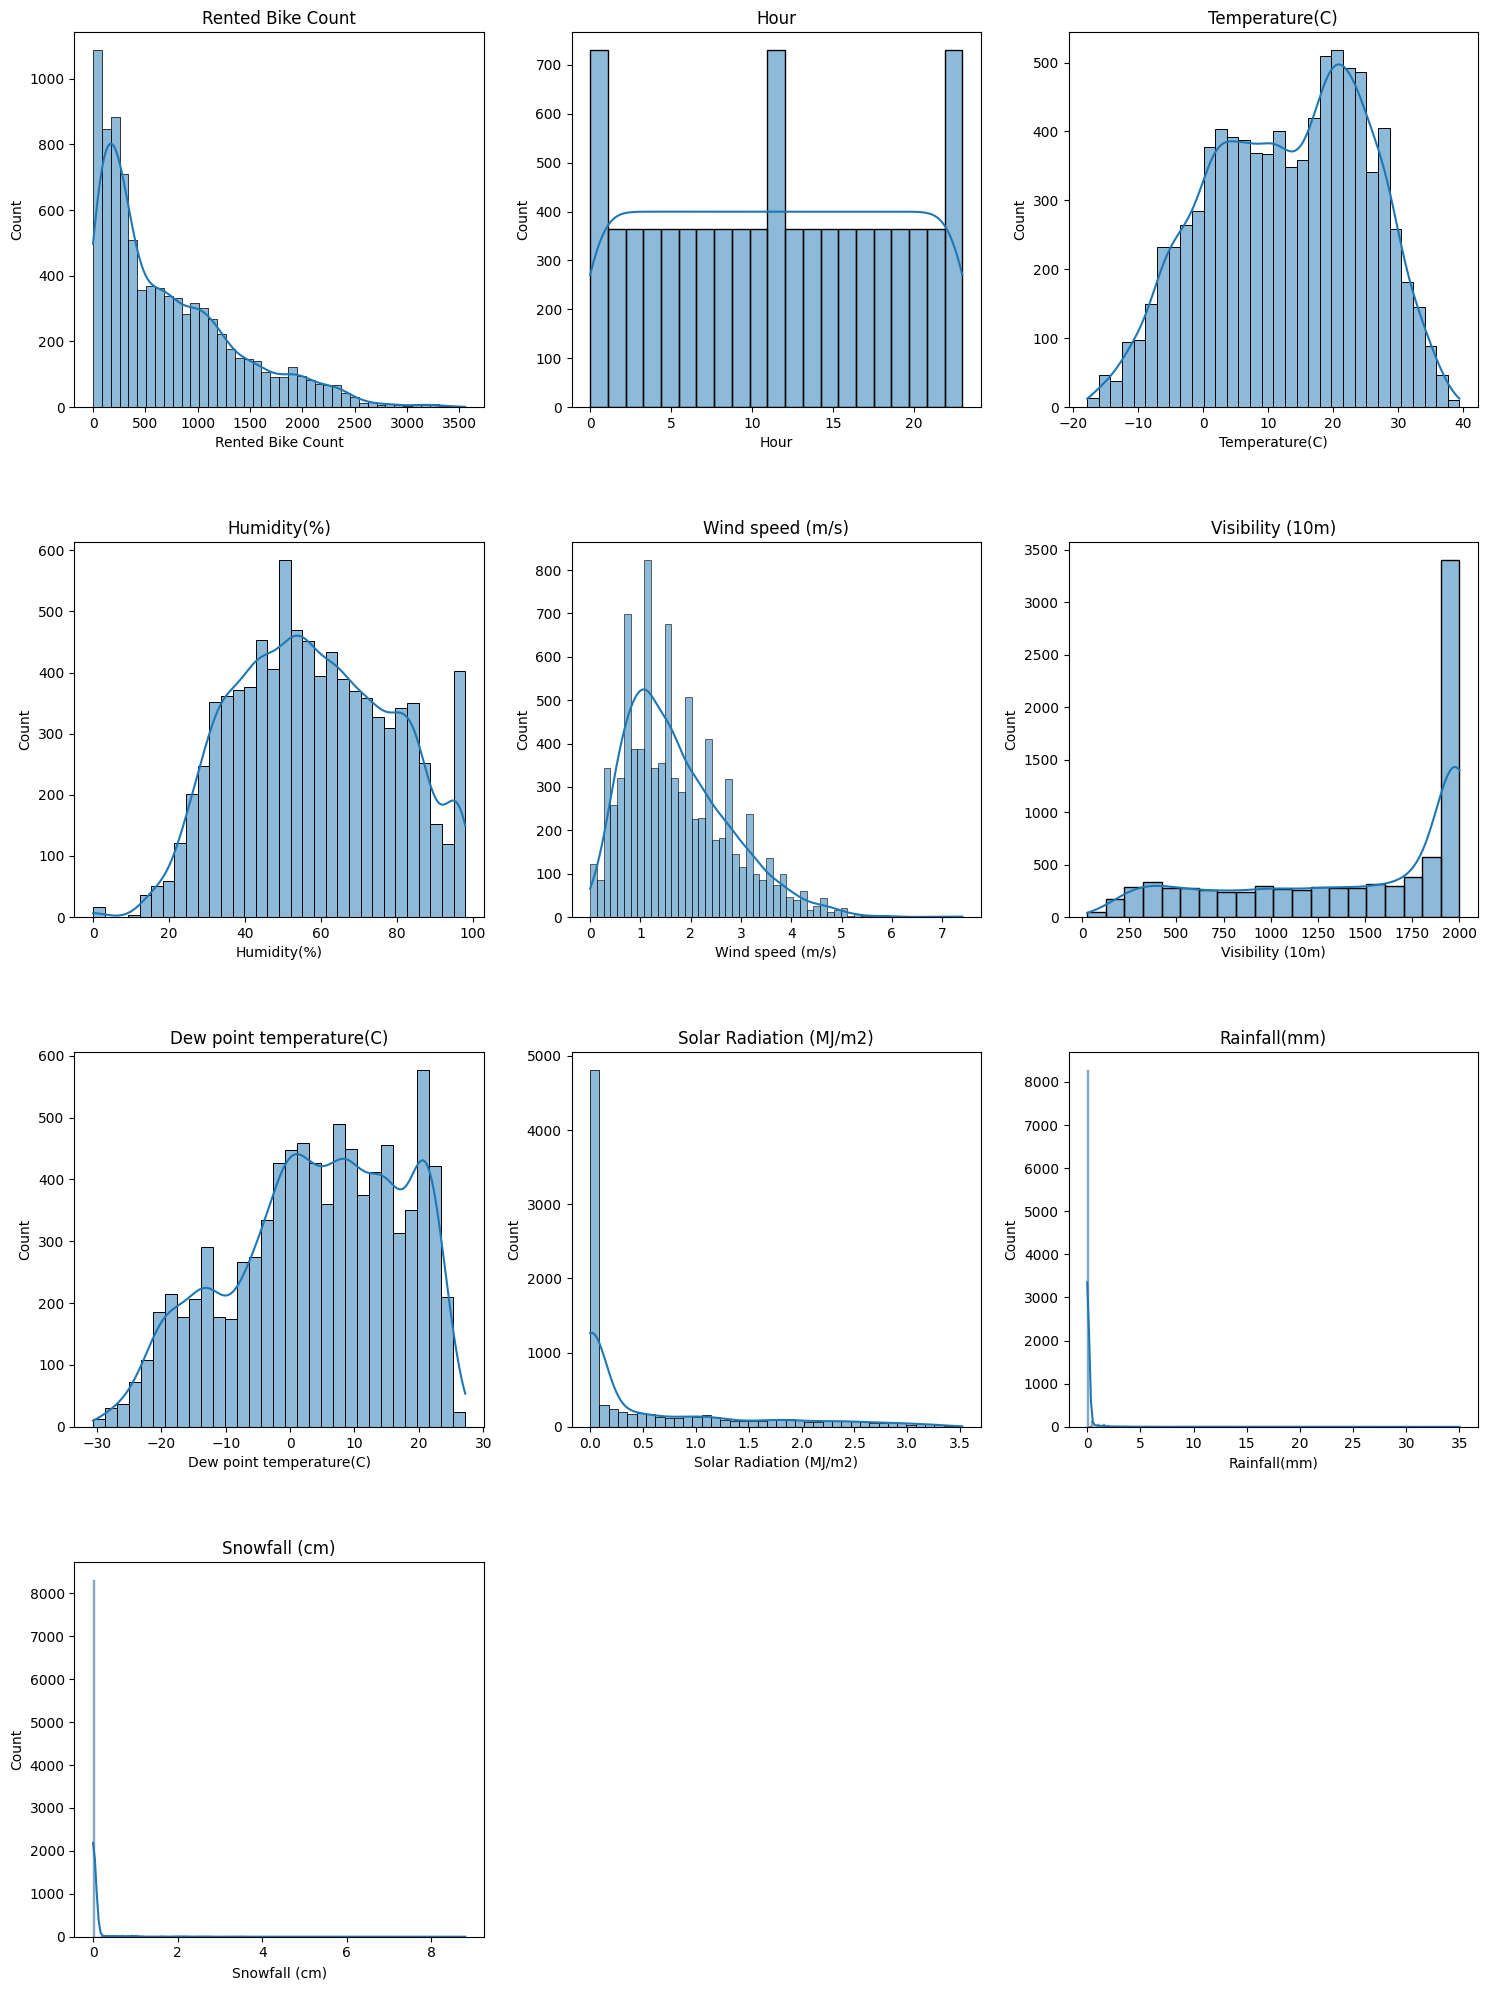

In [581]:
# I need a 3X4 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(number_of_numeric_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((number_of_numeric_cols + 2) // 3)))
axes = axes.flatten()

# Iterate over each numeric column and plot a historbram
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_floridabikerentals, x=col, ax=axes[i], kde=True)
    axes[i].set_title(col)

# Hide the blank/empty graphs
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()  

#### <b>Initial Observations Raw Numeric Feature Histograms</b> ####
    
    Rented Bike Count           - Right Skewed Distribution
    Hour                        - Looks like a Tri-Modal Distribution, as it has 3 peaks (1 at each end, and 1 in the middle)
                                - Possibly related to high use times (morning/evening rush hour/high demand, mid-day high demand)
    Temperature(C)              - Looks "like" a Normalish Distribution
    Humidity(%)                 - Looks "like" a Normalish Distribution - looks like it's got an outlier at the high end
                                - Could be considered Bimodal Distribution with 2 definite peaks
    Wind speed (m/s)            - Right Skewed Distribution
    Visibility (10m)            - Left Skewed Distribution
    Dew point temperature(C)    - Looks "like" a Normalish Distribution - or Bi/Tri-Modal (there's 2-3 peaks)
                                - Related to seasons?
    Solar Radiation (MJ/m2)     - Right Skewed Distribution
    Rainfall(mm)                - Right Skewed Distribution
    Snowfall (cm)               - Right Skewed Distribution

#### <b>Initial Bar Count plots of Raw Categoric (string) Features</b> ####

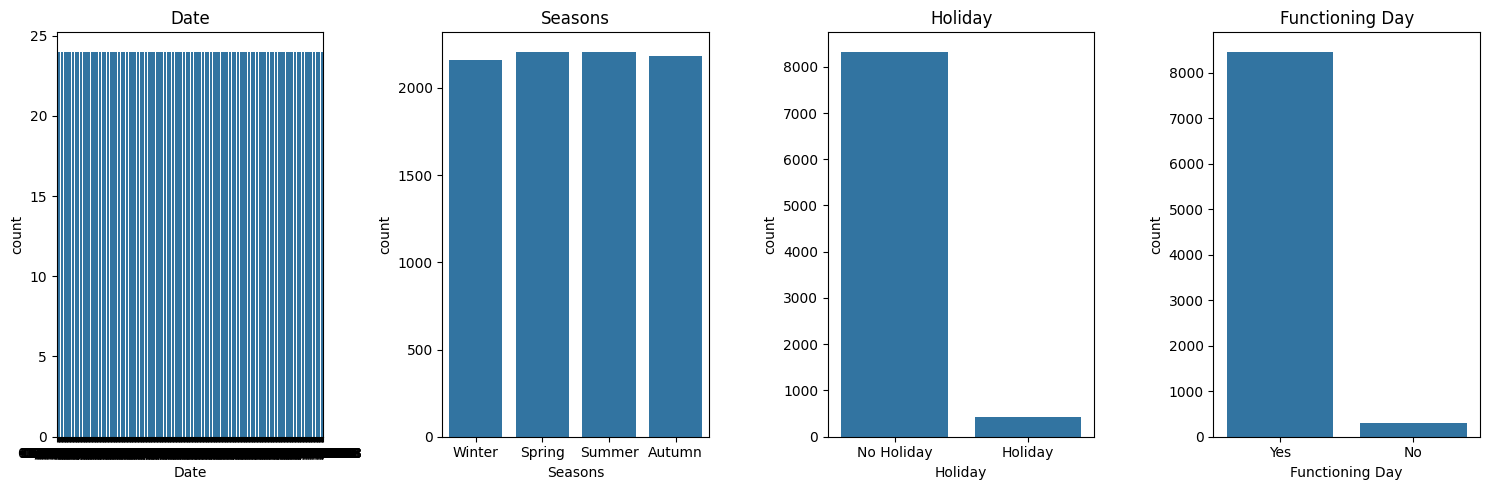

In [582]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

# Iterate over each categoric column and plot a bar count
for i, col in enumerate(original_categoric_cols):
    sns.countplot(data=df_floridabikerentals, x=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

#### <b>Initial Observations Raw Categoric Bar Counts</b> ####
    
    Date                        - There is an even distribution across all dates
    Seasons                     - Looks like there is an even distribution of seasons
    Holiday                     - Many more "No Holiday" days than "Holidays"
    Functioning Day             - Many more bikes rented on "Functioning Days" than non

#### <b>Create Baseline Linear Regression against the Raw Data</b> ####
    To start, I'd like to create a simple Linear Regression model using the "raw" feature data.
    Since Linear Regression requires numerical input features, categorical features will have to be encoded first.
        - Seasons                   - One-Hot Encoding - create a column for each season
        - Date                      - Break apart into Month, Year, and Day Of Week, then One-Hot-Encode    
                                    - Important note: Date is in day/month/year format    
        - Holiday, Functioning Day  - Binary Encoding, since both Features can only be 1 of 2 values

##### <b>Encode the Categorical Features</b> #####

In [583]:
#
# Encode Categorical Features
#

df_floridabikerentals_nonengineered = df_floridabikerentals.copy(deep=True)

def EncodeCategoricalFeatures(df_target):

    encoder = OneHotEncoder(sparse_output=False, drop='first')

    #
    # Encode Seasons
    #
    onehot_array = encoder.fit_transform(df_target[['Seasons']])

    # Create dataframe with proper column names
    df_onehot = pd.DataFrame(
        onehot_array,
        columns=encoder.get_feature_names_out(['Seasons']),
        index=df_target.index
    )

    # Join back to original and drop original column
    df_target = pd.concat([df_target, df_onehot], axis=1)
    df_target = df_target.drop('Seasons', axis=1)

    # Split Date into Day, Month, Year
    df_target['Date'] = pd.to_datetime(df_target['Date'], format='%d/%m/%Y')

    df_target['Month'] = df_target['Date'].dt.month
    df_target['DayOfWeek'] = df_target['Date'].dt.dayofweek    # 0=Monday, 6=Sunday
    #df_target['DayOfYear'] = df_target['Date'].dt.dayofyear
    #df_target['Weekend'] = (df_target['Date'].dt.dayofweek >= 5).astype(int)
    df_target['Year'] = df_target['Date'].dt.year

    # Fix Year - Negatively Skewed Coeffs
    # Fix 1: Normalize Year
    df_target['Year'] = df_target['Year'] - df_target['Year'].min()
    df_target = df_target.drop('Date', axis=1)

    # print("Year min:", df_target['Year'].min())
    # print("Year max:", df_target['Year'].max())

    df_target['Holiday'] = df_target['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df_target['Functioning Day'] = df_target['Functioning Day'].map({'No': 0, 'Yes': 1})

    return df_target

# Call Encoder function
df_floridabikerentals_nonengineered = EncodeCategoricalFeatures(df_floridabikerentals_nonengineered)
PrintDataFrameStatus(df_floridabikerentals_nonengineered)


***********************************
Description Stats
***********************************

                           count         mean         std   min     25%      50%      75%      max
Rented Bike Count         8760.0   704.602055  644.997468   0.0  191.00   504.50  1065.25  3556.00
Hour                      8760.0    11.500000    6.922582   0.0    5.75    11.50    17.25    23.00
Temperature(C)            8760.0    12.882922   11.944825 -17.8    3.50    13.70    22.50    39.40
Humidity(%)               8760.0    58.226256   20.362413   0.0   42.00    57.00    74.00    98.00
Wind speed (m/s)          8760.0     1.724909    1.036300   0.0    0.90     1.50     2.30     7.40
Visibility (10m)          8760.0  1436.825799  608.298712  27.0  940.00  1698.00  2000.00  2000.00
Dew point temperature(C)  8760.0     4.073813   13.060369 -30.6   -4.70     5.10    14.80    27.20
Solar Radiation (MJ/m2)   8760.0     0.569111    0.868746   0.0    0.00     0.01     0.93     3.52
Rainfall(mm)      

##### <b>Create Initial Linear Regression</b> #####
    - Create and run Linear Regression Model
    - Examine Statistics
    - Plot the results

Training RMSE: 425.3866

Testing RMSE: 449.2861




C:\Users\jxbma\AppData\Local\Temp\ipykernel_41648\3675404125.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
C:\Users\jxbma\AppData\Local\Temp\ipykernel_41648\3675404125.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


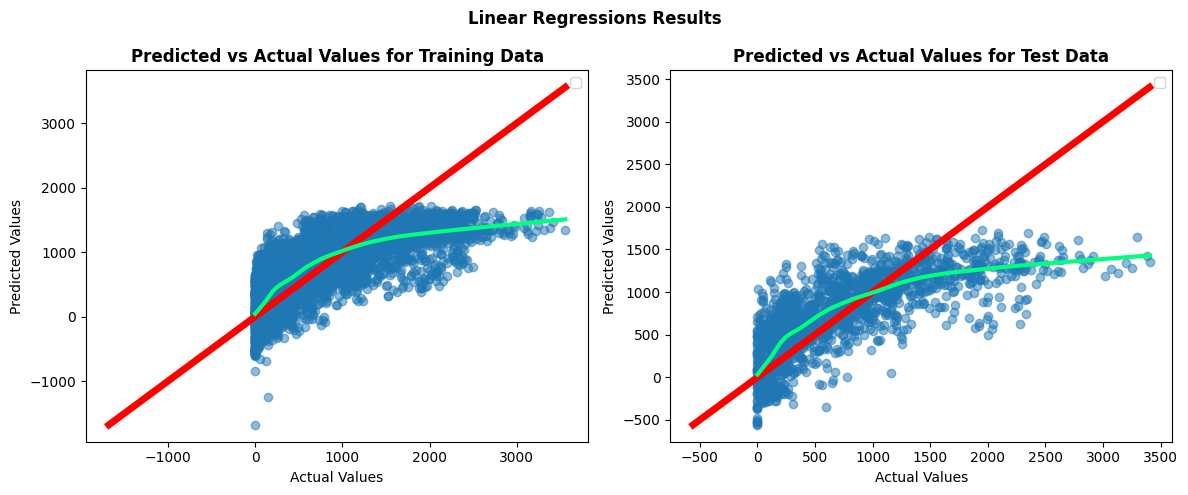

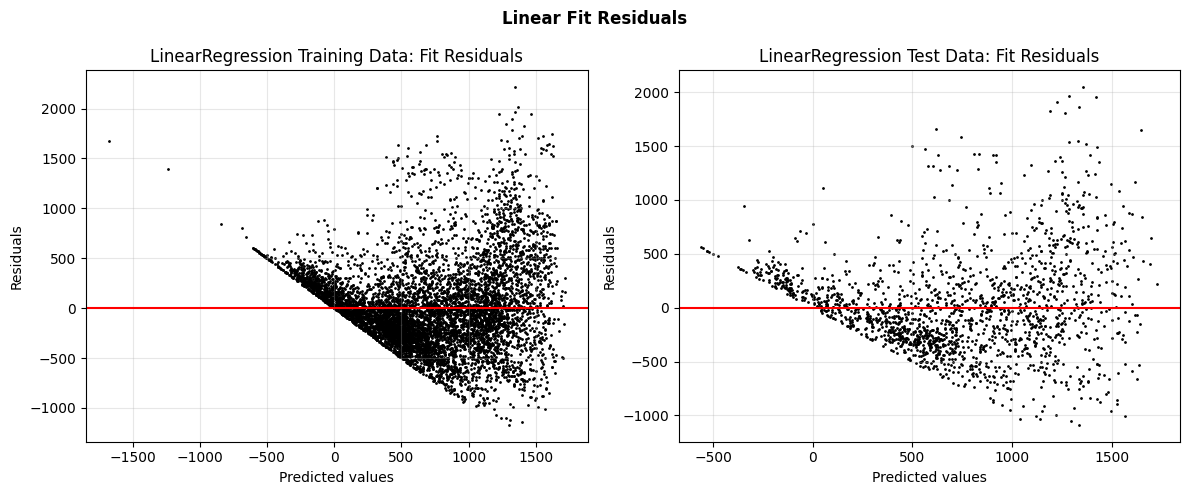



----------------------------------------------
Model Coefficients
[ 2.69650825e+01  1.85827282e+01 -1.04600490e+01  1.90556704e+01
  9.24197766e-03  8.75337452e+00 -8.04979542e+01 -5.61133178e+01
  3.02223000e+01 -1.18338127e+02  9.23132890e+02 -4.30816508e+02
 -2.94784832e+02 -7.96634889e+02 -4.82014073e+01 -1.22989096e+01
 -5.98459336e+02]
----------------------------------------------



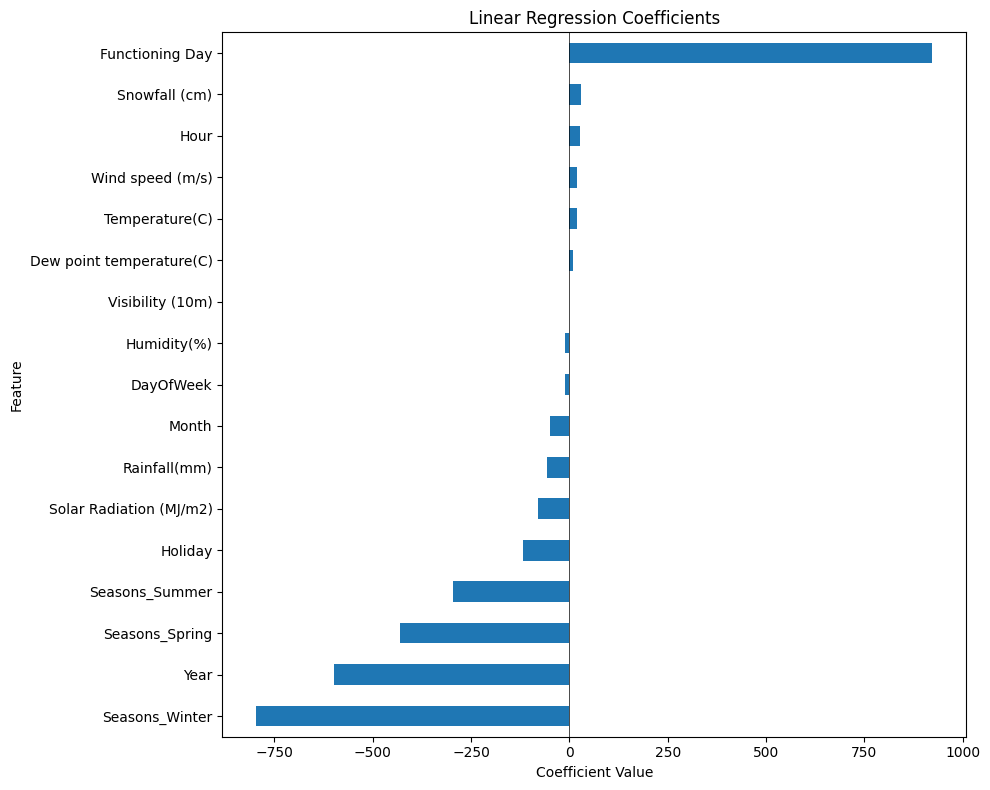


Training RMSE: 425.3866
Testing RMSE: 449.2861




In [584]:
#
# Create Linear Regression
#

def RunLinearRegression(df_target, target_label):

    X = df_target.drop(target_label, axis=1)  # DataFrame
    y = df_target[target_label]               # Series

    #
    # Split Data into Training/Test => 80/20
    #
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=315)


    linear_regression_model = LinearRegression()

    fit_result = linear_regression_model.fit( 
                                                X_train,
                                                y_train
                                            )

    train_predictions = linear_regression_model.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, train_predictions)
    print(f'Training RMSE: {train_rmse:.4f}')
    print()

    test_predictions = linear_regression_model.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    print(f'Testing RMSE: {test_rmse:.4f}')
    print()
    print()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.suptitle('Linear Regressions Results', fontweight='bold')

    #
    # Train Data
    #
    # Plots
    axes[0].scatter(y_train, train_predictions, alpha=0.5)
    min_val = min(y_train.min(), train_predictions.min())
    max_val = max(y_train.max(), train_predictions.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r', linewidth=5)

    # LOWESS smooth line - method for showing true relationship as predictions trend against actual
    smoothed = lowess(train_predictions, y_train, frac=0.3)
    axes[0].plot(smoothed[:, 0], smoothed[:, 1], color='springgreen', linewidth=3)

    # Labels
    axes[0].set_title('Predicted vs Actual Values for Training Data', fontweight='bold')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].legend()

    #
    # Test Data
    #
    # Plots
    axes[1].scatter(y_test, test_predictions, alpha=0.5)
    min_val = min(y_test.min(), test_predictions.min())
    max_val = max(y_test.max(), test_predictions.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r', linewidth=5)

    # LOWESS smooth line
    smoothed = lowess(test_predictions, y_test, frac=0.3)
    axes[1].plot(smoothed[:, 0], smoothed[:, 1], color='springgreen', linewidth=3)

    # Labels
    axes[1].set_title('Predicted vs Actual Values for Test Data', fontweight='bold')
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].legend()
    
    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()   
    print()
    print()


    # Plot Residuals
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.suptitle('Linear Fit Residuals', fontweight='bold')

    #
    # Train Data
    #
    residuals_lr = y_train - train_predictions
    axes[0].set_title('LinearRegression Training Data: Fit Residuals')
    axes[0].scatter(train_predictions, residuals_lr, c='black', s=1)
    axes[0].axhline(y=0, color='r')
    axes[0].set_xlabel('Predicted values')
    axes[0].set_ylabel('Residuals')
    axes[0].grid(True, alpha=0.3)

    #
    # Test Data
    #
    residuals_lr = y_test - test_predictions
    axes[1].set_title('LinearRegression Test Data: Fit Residuals')
    axes[1].scatter(test_predictions, residuals_lr, c='black', s=1)
    axes[1].axhline(y=0, color='r')
    axes[1].set_xlabel('Predicted values')
    axes[1].set_ylabel('Residuals')
    axes[1].grid(True, alpha=0.3)

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()   
    print()
    print()

    #
    #  Plot Linear Coefficients
    #
    print('----------------------------------------------')
    print('Model Coefficients')
    print(fit_result.coef_)
    print('----------------------------------------------')
    print()

    coefficients = pd.Series(linear_regression_model.coef_, index=X_train.columns)
    coefficients_sorted = coefficients.sort_values()

    plt.figure(figsize=(10, 8))
    coefficients_sorted.plot(kind='barh')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Linear Regression Coefficients')
    plt.axvline(x=0, color='black', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    print()
    print(f'Training RMSE: {train_rmse:.4f}')
    print(f'Testing RMSE: {test_rmse:.4f}')
    print()

# Run the Linear Regression and plot/display results
RunLinearRegression(df_floridabikerentals_nonengineered, 'Rented Bike Count')
print()


##### <b>Analysis of Initial Linear Regression</b> #####
    - Actual versus predicted value scatter plot
        Red line indicates perfect predictions and green line shows actual model performance.
        Model starts out roughly following perfect predictions, but begins to curve as bike demand increases
        Model does not perform well as demand of bikes increases (under predicts)

    - Residuals Plot
        If this was a good model, the points would be scattered closely around the zero line.
        Reinforces findings of Scatter Plot - points are not even distributed
        Wider spread of residuals as bike demand increases (higher errors/differences)

    - Model Coefficients
        Coeffients tell us how much each feature affects the prediction (positive/negative)
        "Functioning Day" has the highest positive effect
        Visibility appears to have little or no effect
        Seasons have high effect - worse season (Winter/Spring) negatively affects outcome
        General reported weather conditions seem to have a low effect


## <u>**2. Data Wrangling**</u> ##

The next step is to clean/transform model features in a more usable/performant form.</br>


##### <b>Encode the Categorical Features</b> #####
    The first step is to encode the categorical features into numeric values.
    We did this previously to test on the raw data. Just repeat the process here.

In [585]:
#
# Encode the data
#

df_floridabikerentals_new = EncodeCategoricalFeatures(df_floridabikerentals_new)
#PrintDataFrameStatus(df_floridabikerentals_new)
print('Feature Encoding Completed')

Feature Encoding Completed


#### <b>Data Type Conversion</b> ####
    The next step is to convert data types into optimal performance types
        Rented Bike Count         int64     ==> int16    
        Hour                      int64     ==> int8    
        Humidity(%)               int64     ==> int8    
        Visibility (10m)          int64     ==> int16    
        Holiday                   int64     ==> int8    
        Functioning Day           int64     ==> int8  
        Seasons_Spring            float64	==> int8
        Seasons_Summer            float64   ==> int8
        Seasons_Winter            float64   ==> int8
        Month                     int32     ==> int8
        DayOfWeek                 int32     ==> int8
        Year                      int32     ==> int8  

    Looking at Visibility in terms of 10m increments seems a little odd.
    Normalize this to be actual meters (multiply values by 10) and rename the column.

In [586]:
# Data Type Conversions

columns = ['Hour','Humidity(%)','Holiday','Functioning Day','Seasons_Spring', 
           'Seasons_Summer','Seasons_Winter','Month','DayOfWeek','Year' ]
df_floridabikerentals_new[columns] = df_floridabikerentals_new[columns].astype('int8')

columns = ['Rented Bike Count','Visibility (10m)']
df_floridabikerentals_new[columns] = df_floridabikerentals_new[columns].astype('int16')

# Normalize Visibility column
df_floridabikerentals_new['Visibility'] = (df_floridabikerentals_new['Visibility (10m)'] * 10).astype('int16')
df_floridabikerentals_new = df_floridabikerentals_new.drop('Visibility (10m)', axis=1)

#PrintDataFrameStatus(df_floridabikerentals_new)
print('Data Type Conversions Completed')


Data Type Conversions Completed


#### <b>Plot Correlations between Features and Predicted Bike Rentals</b> ####
Plot the correlation between all the features relative to bike rentals

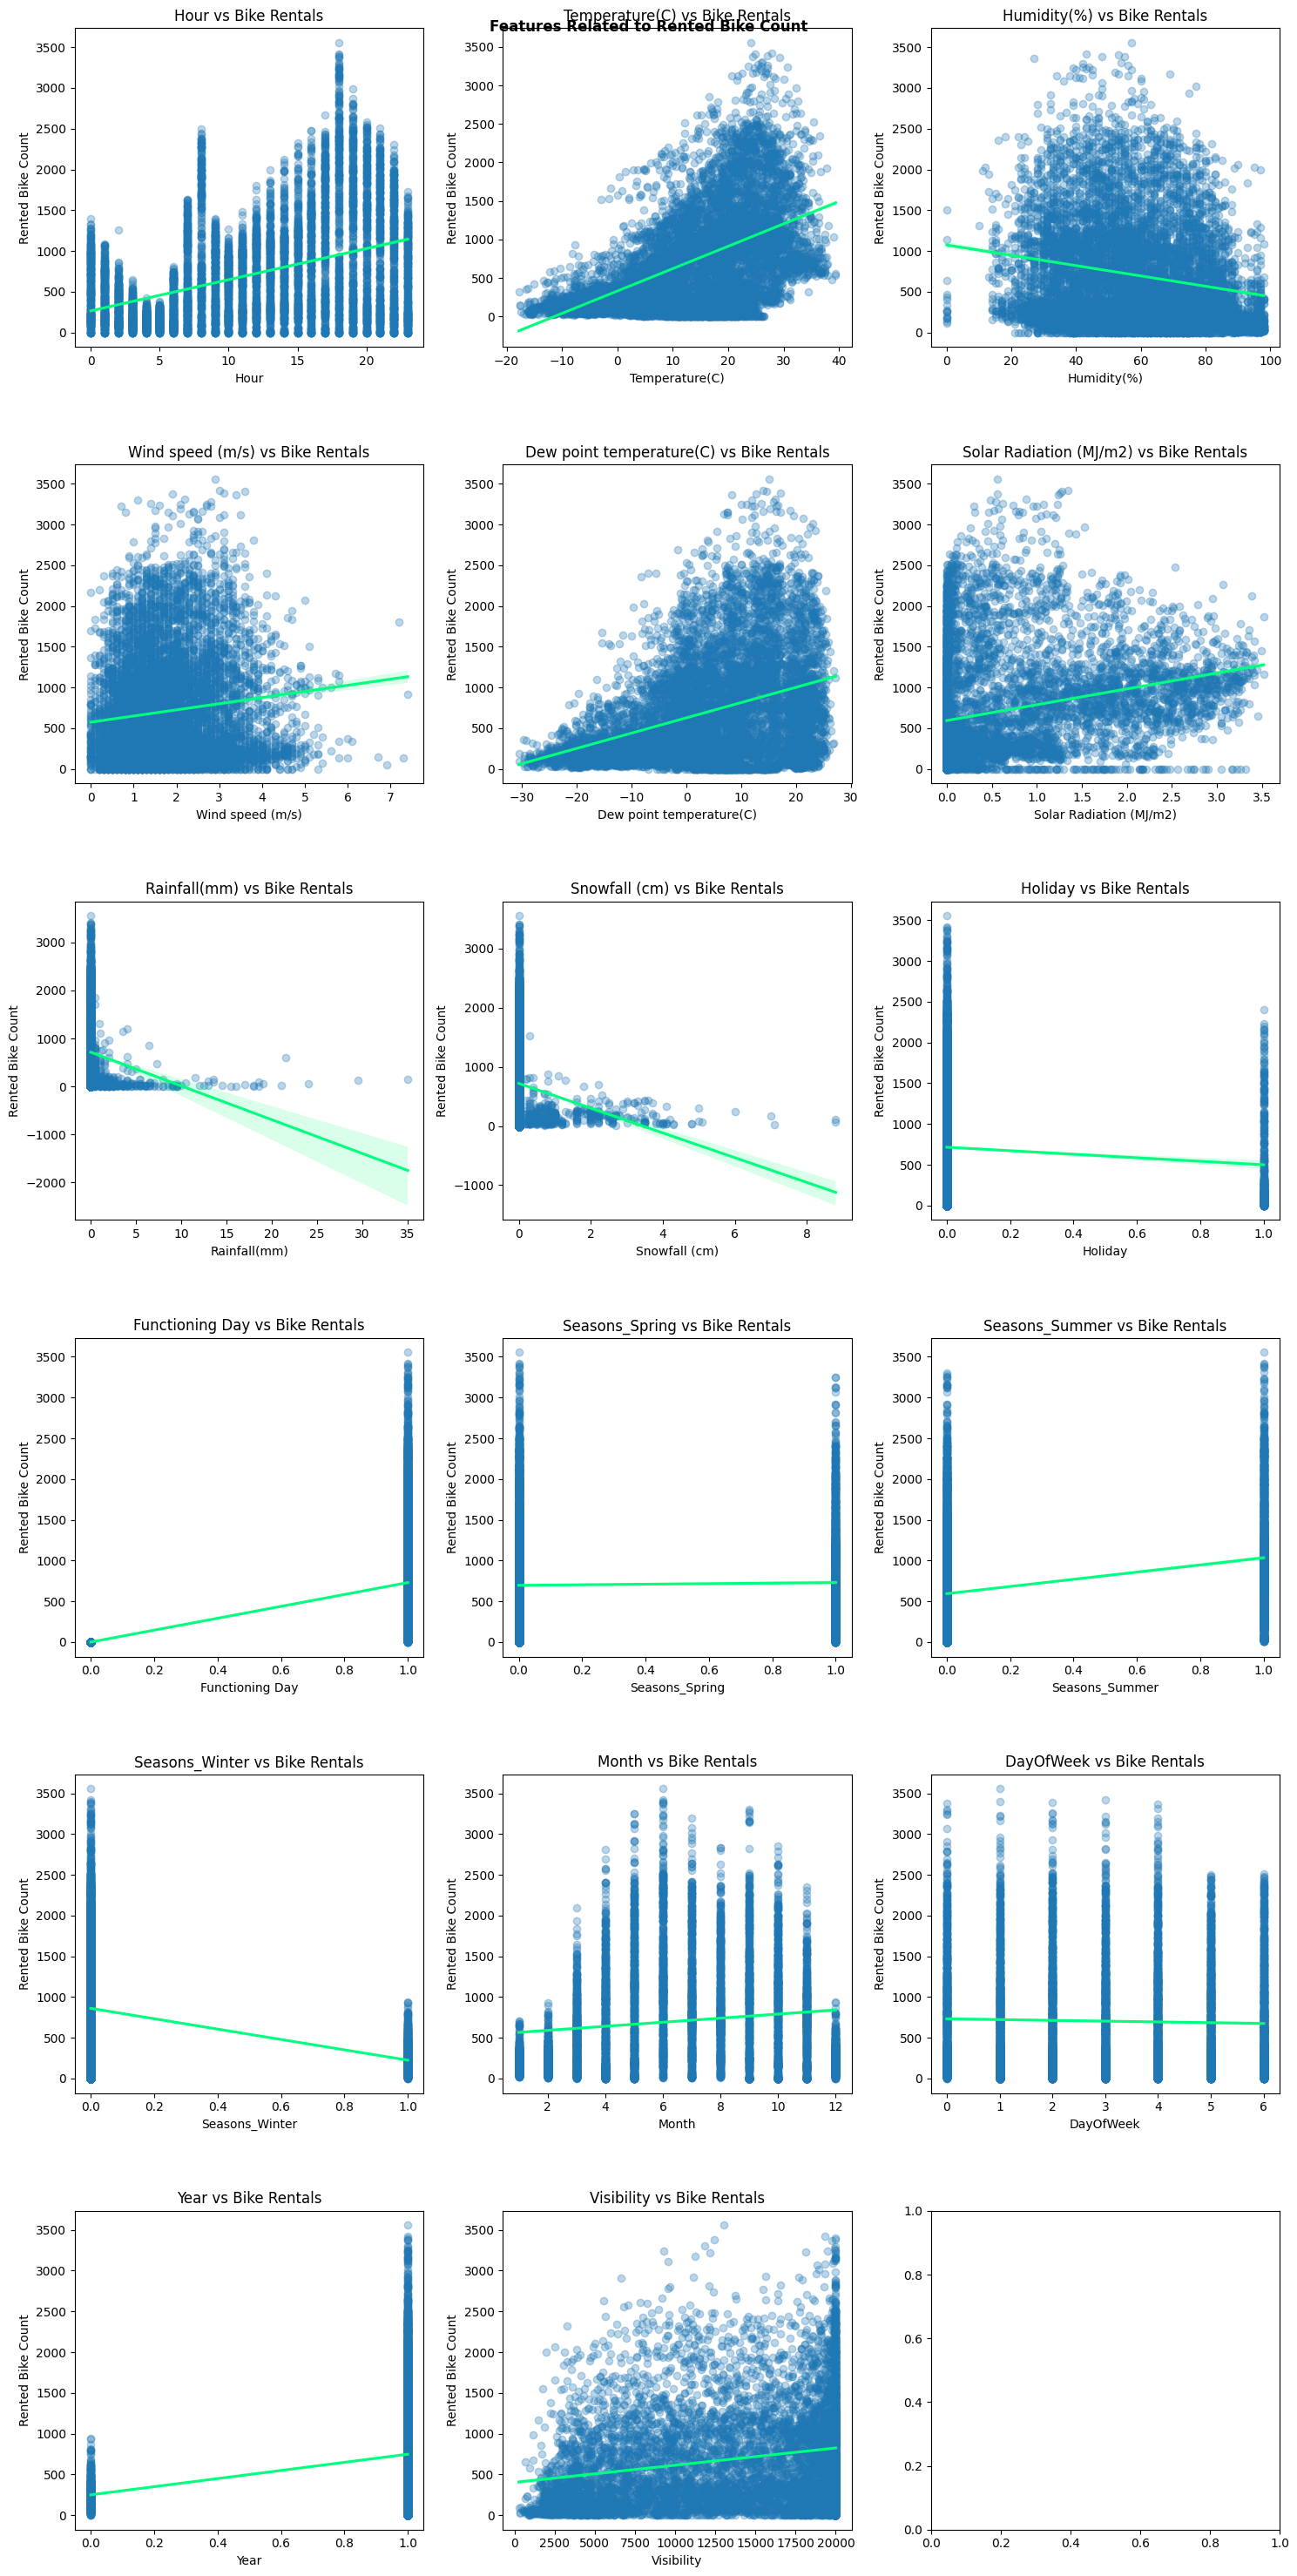

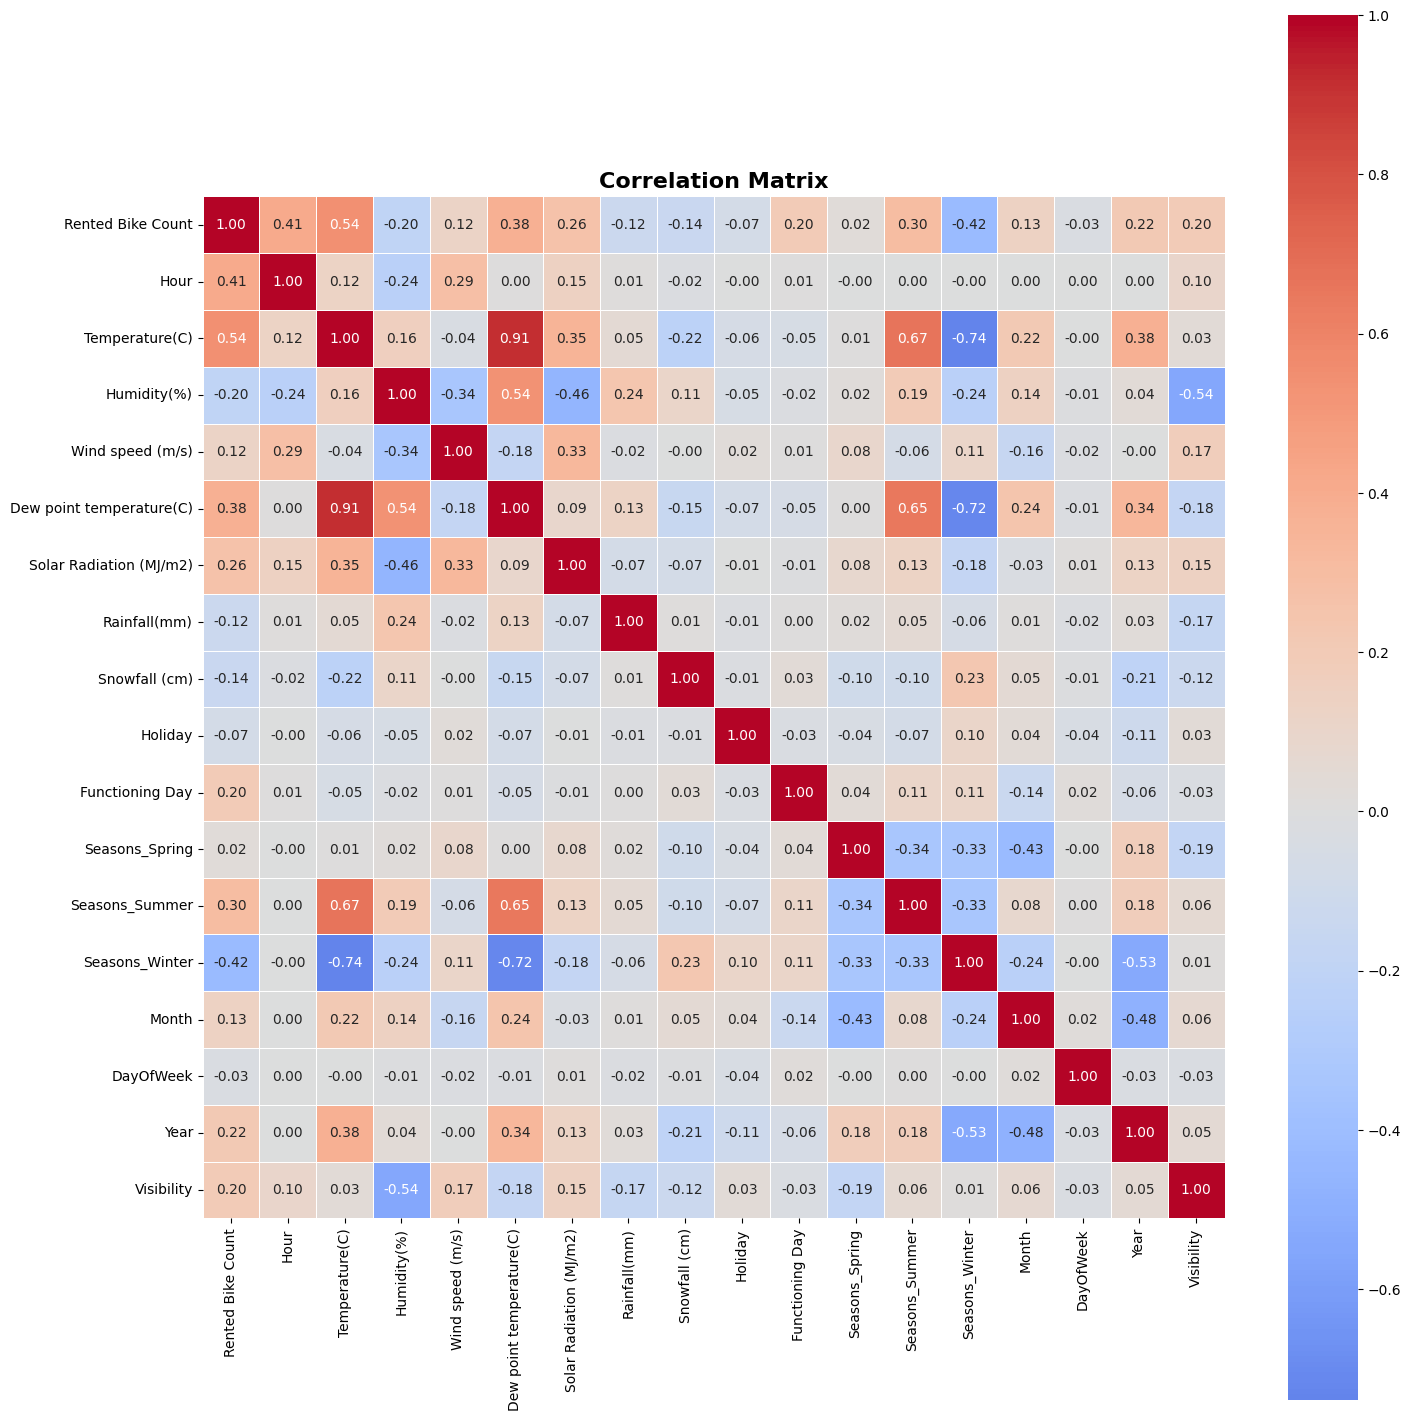

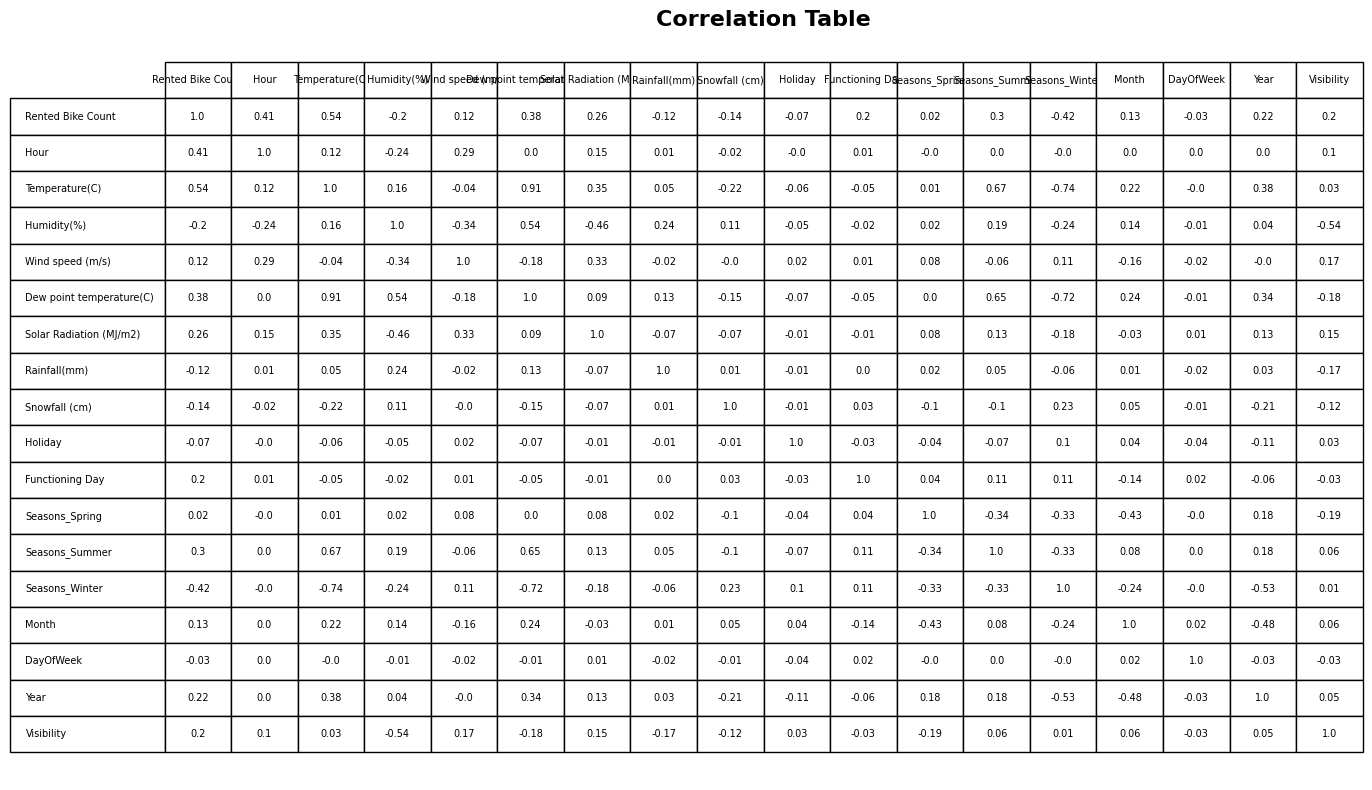

In [587]:
#
# Features to Bike Rentals Correlations
#

def DisplayFeatureCorrelationInfo(df_Target):
    columns = df_Target.columns.drop('Rented Bike Count').tolist()
    n_cols = len(columns)

    fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))

    axes = axes.flatten()

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top
    plt.suptitle('Features Related to Rented Bike Count', fontweight='bold')

    for i, col in enumerate(columns):
        sns.regplot(data=df_Target, x=col, y='Rented Bike Count', 
                    scatter_kws={'alpha': 0.3}, ax=axes[i],
                    line_kws={'color': 'springgreen'})
        axes[i].set_title(f'{col} vs Bike Rentals')

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()  
    print()
    print()

    corr = df_Target.corr()
    # print(type(corr))
    # print(corr)

    # Create heatmap
    plt.figure(figsize=(15, 15))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print()
    print()

    # Table

    plt.figure(figsize=(14, 8))
    plt.axis('off')
    table = plt.table(
        cellText=corr.round(2).values,
        rowLabels=corr.index,
        colLabels=corr.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.2, 1.8)
    plt.title('Correlation Table', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

DisplayFeatureCorrelationInfo(df_floridabikerentals_new)


#### <b>Additional Potential Data Issues from Imported Data</b> ####
Examining Features for potential issues - (missing values?)
### ###
    Humidity(%)               8760.0     58.226256    20.362413    0.0    42.00     57.00     74.00     98.00
    Wind speed (m/s)          8760.0      1.724909     1.036300    0.0     0.90      1.50      2.30      7.40
    Dew point temperature(C)  8760.0      4.073813    13.060369  -30.6    -4.70      5.10     14.80     27.20
    Solar Radiation (MJ/m2)   8760.0      0.569111     0.868746    0.0     0.00      0.01      0.93      3.52

    Wind Speed - Its possible to have a totally calm day with absolutely no wind. We can't discern between real calm
    days and instances of missing/bad data. Leave it as it is.

    Solar Radiation - It's possible to have zero (0) Solar Radiation - night time. We can't discern between night time
    (legitimate) and missing data. Leave it as is.

    Humidity - Zero (0) percent humidity is extremely rare (even in desert climates). These values should be considered
    suspicious and treated as missing data. We should either treat as missing values or establish a reasonable threshold 
    and apply it to the feature. Given this data set originates from Florida, exceedingly now humidity is highly improbable.
    Establish a reasonable lower bounds threshold.

    Dew Point Temperature - a dew point temeprature of -30.6 degrees is highly unlikely and should be treated as 
    bad/suspicious data, especially given that our data set is Florida based, which is typically a hot/warm/humid evironment.
    We should establish a reasonable threshold and apply it to the feature.

#### <b>Histogram plots of Humidity and Dew Point</b> ####

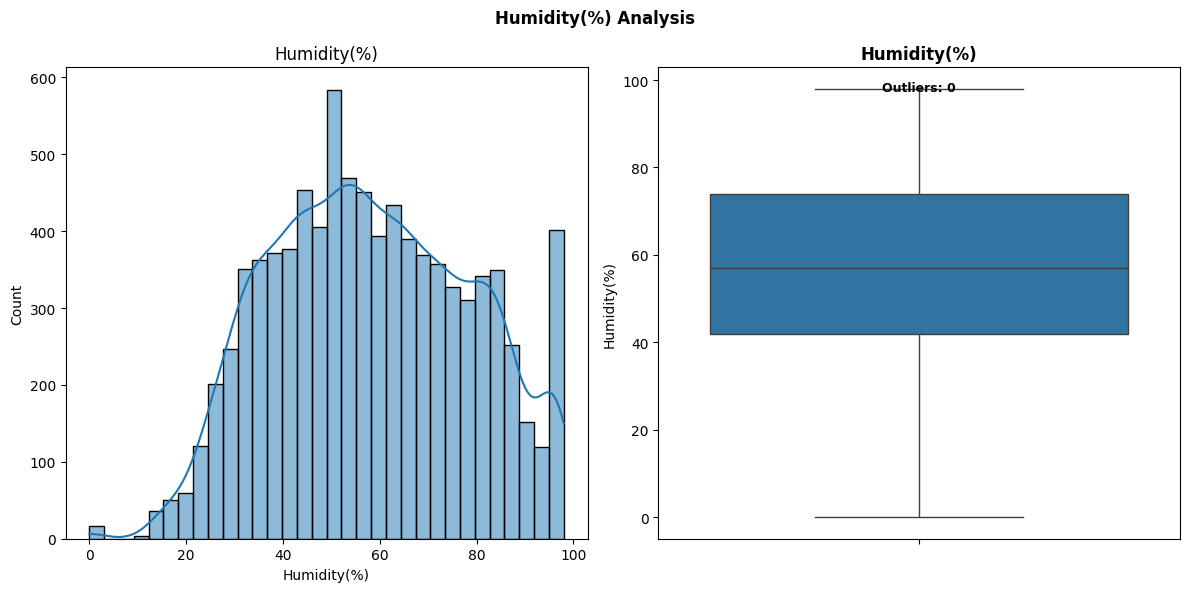

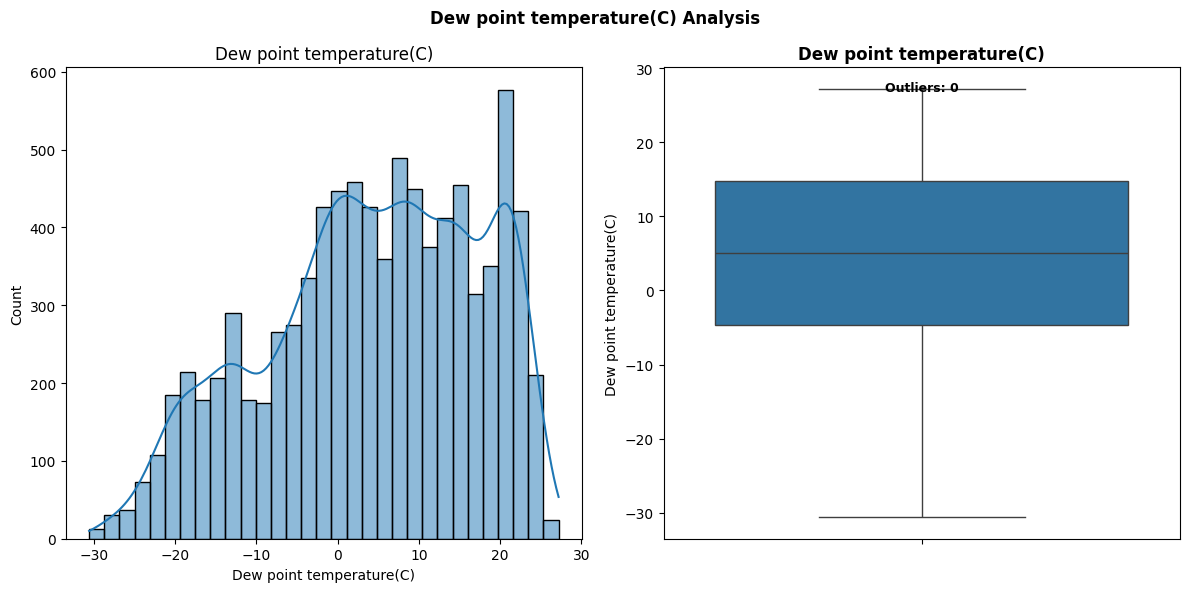

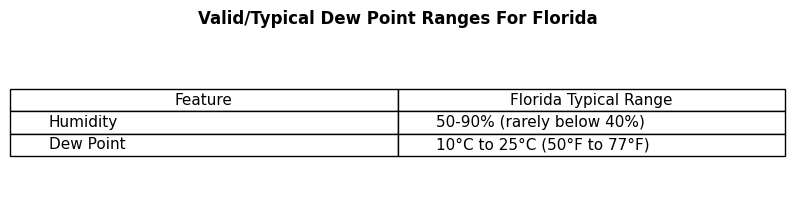



Number of rows in the data set:8760
Humidity below 30%:641
Percentage of DataSet with Humidity Data Issues:7.32%
Dew Point below 0°C: 3138
Percentage of DataSet with Dew Point Data Issues:35.82%


In [588]:

columns = ['Humidity(%)','Dew point temperature(C)']

for i, col in enumerate(columns):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axes = axes.flatten()

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top
    plt.suptitle(f'{col} Analysis', fontweight='bold')

    # Histogram
    iPlot = 0
    sns.histplot(data=df_floridabikerentals_new, x=col, ax=axes[iPlot], kde=True)
    axes[iPlot].set_title(col)
    iPlot += 1

    # BoxPlot
    sns.boxplot(data=df_floridabikerentals_new, y=col, ax=axes[iPlot])    
    axes[iPlot].set_title(col, fontweight='bold')

    # Optional: Add count of outliers
    Q1 = df_floridabikerentals_new[col].quantile(0.25)
    Q3 = df_floridabikerentals_new[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = len(df_floridabikerentals_new[(df_floridabikerentals_new[col] < lower) | 
                                        (df_floridabikerentals_new[col] > upper)])
    axes[iPlot].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                transform=axes[iPlot].transAxes, ha='center', fontsize=9, fontweight='bold')

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()  
    print()
    print()

print()
print()

fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')

plt.suptitle(f'Valid/Typical Dew Point Ranges For Florida', fontweight='bold')

table_data = [
    ['Humidity', '50-90% (rarely below 40%)'],
    ['Dew Point', '10°C to 25°C (50°F to 77°F)']
]

table = ax.table(
    cellText=table_data,
    colLabels=['Feature', 'Florida Typical Range'],
    loc='center',
    cellLoc='left'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

plt.tight_layout(h_pad=5)
plt.show()   
print()
print()

print(f'Number of rows in the data set:{len(df_floridabikerentals_new)}')
bad_values = (df_floridabikerentals_new['Humidity(%)'] < 30).sum()
print(f"Humidity below 30%:{bad_values}")
percentage_of_errors = (bad_values/len(df_floridabikerentals_new)) * 100
print(f'Percentage of DataSet with Humidity Data Issues:{percentage_of_errors:.2f}%')

bad_values = (df_floridabikerentals_new['Dew point temperature(C)'] < 0).sum()
print(f"Dew Point below 0°C: {bad_values}" )
percentage_of_errors = (bad_values/len(df_floridabikerentals_new)) * 100
print(f'Percentage of DataSet with Dew Point Data Issues:{percentage_of_errors:.2f}%')

#### <b>Humidity and Dew Point Plot Analysis</b> ####
    First, there don't appear to be any outliers for Dew Point or Humidity.
    
    Examining the typical Humidity/Dew Point ranges as they relate to our data set, 
    we see substantial values which are outside of the expected range (on the negative side).
    
    Humidity - approximately 7% of the data values are below expected norms. Clip the data.

    Dew Point - 36% of the data is outside the expected norms. Is there a strong direct correlation between humidity and bike rentals?
        Options include:
            - Drop the feature - 36% of it looks questionable
            - Keep it as is 
            - Select a new less restrictive threshold.
            
    Course of action - drop the column. We can always come back and re-evaluate this.

    

In [589]:
#
# Clip Humidity
#
df_floridabikerentals_new['Humidity(%)'] = df_floridabikerentals_new['Humidity(%)'].clip(lower=30)

#
# Drop Humidity
#
df_floridabikerentals_new = df_floridabikerentals_new.drop('Dew point temperature(C)', axis=1)


#### <b>Adding New (Complex/Combination) New Features to DataSet</b> ####

##### <b>Add Features</b> #####
    Create new features:
        - Normalized (Ratio)
        - Difference Features
        - Tranformed (log/sqrt)
        - Free Form Features

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


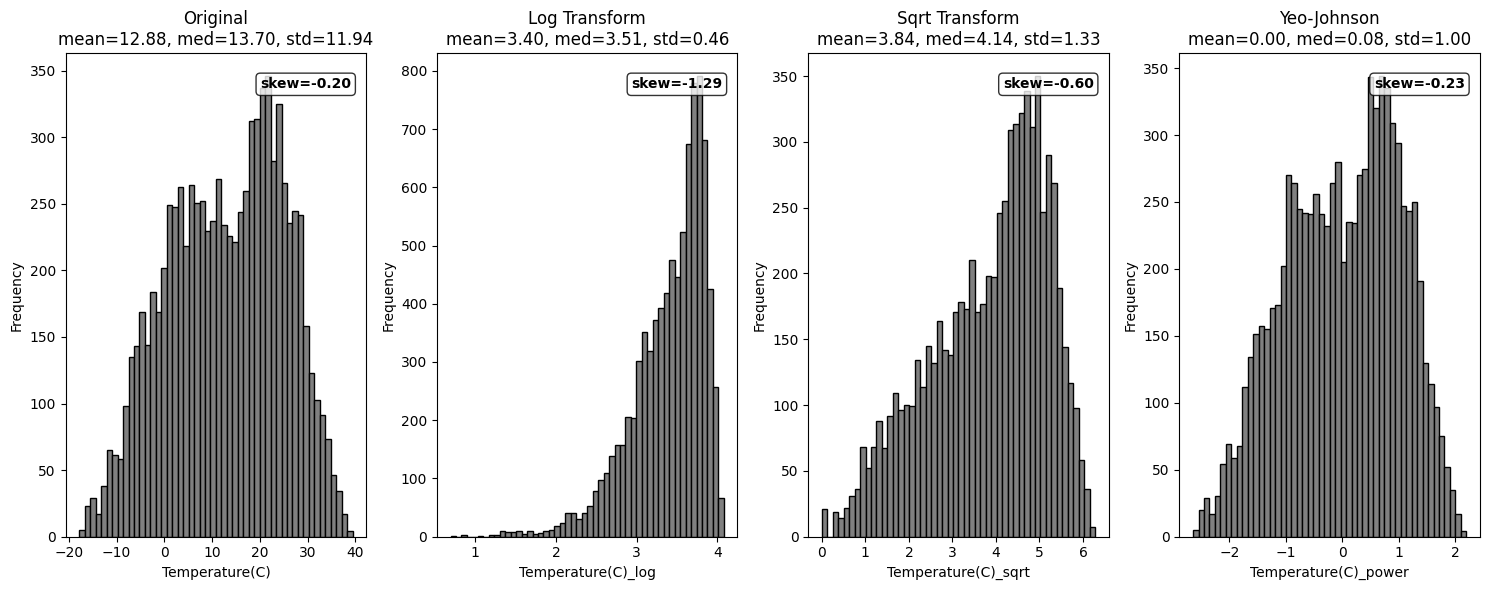

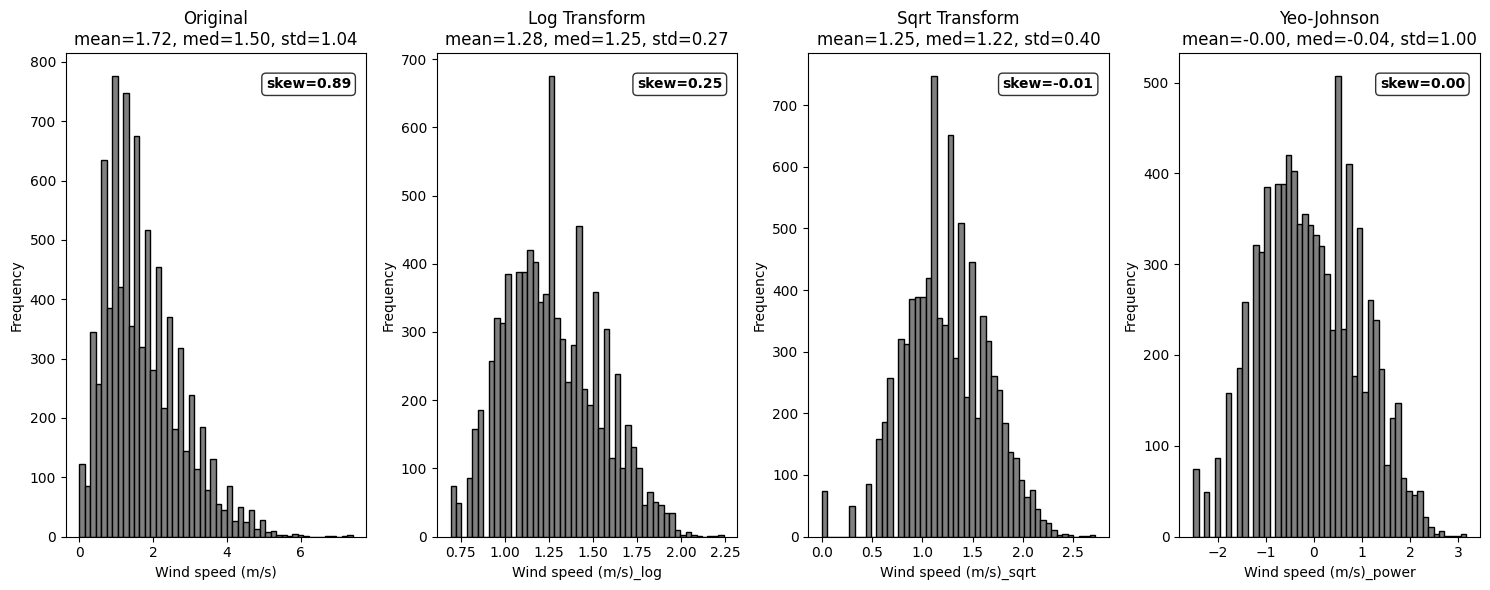

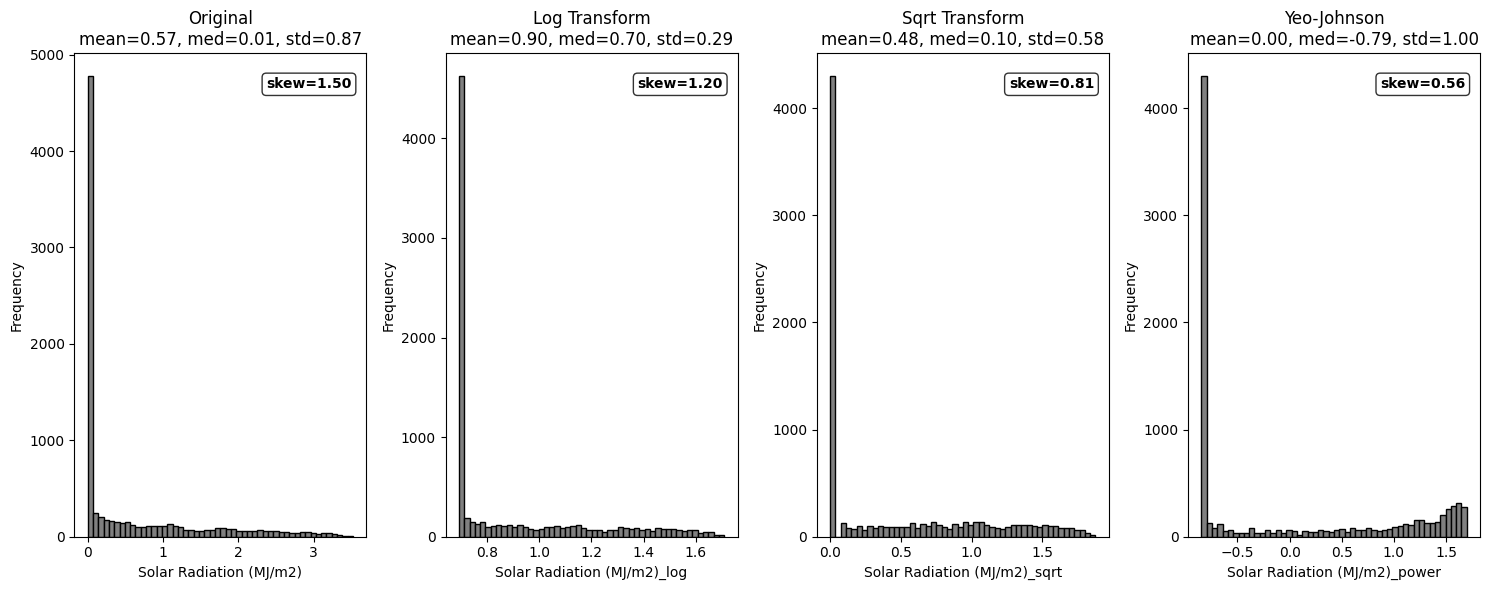

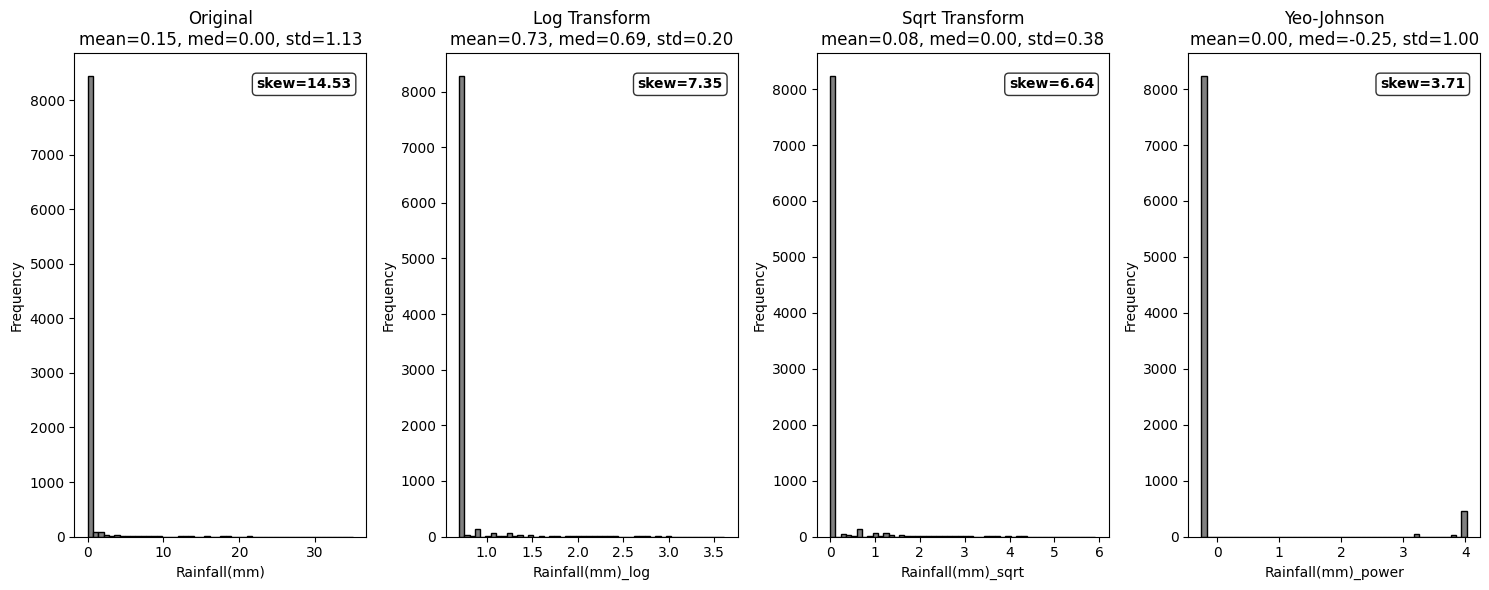

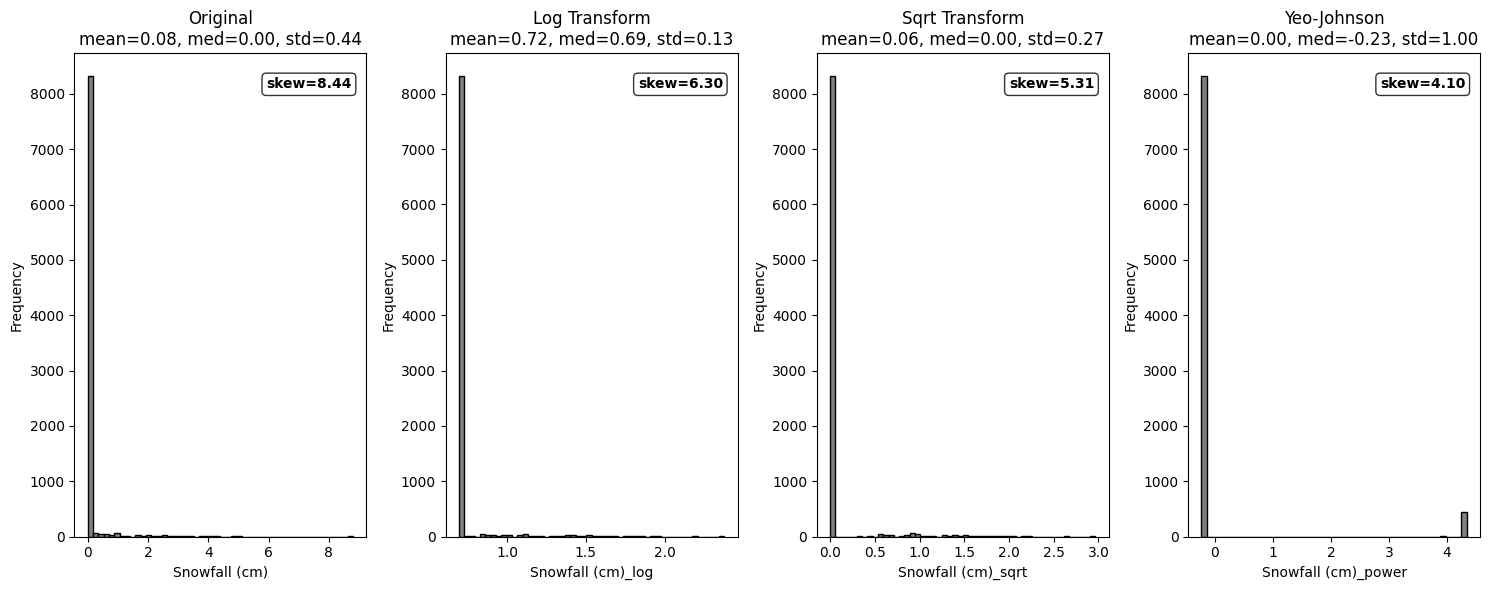

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


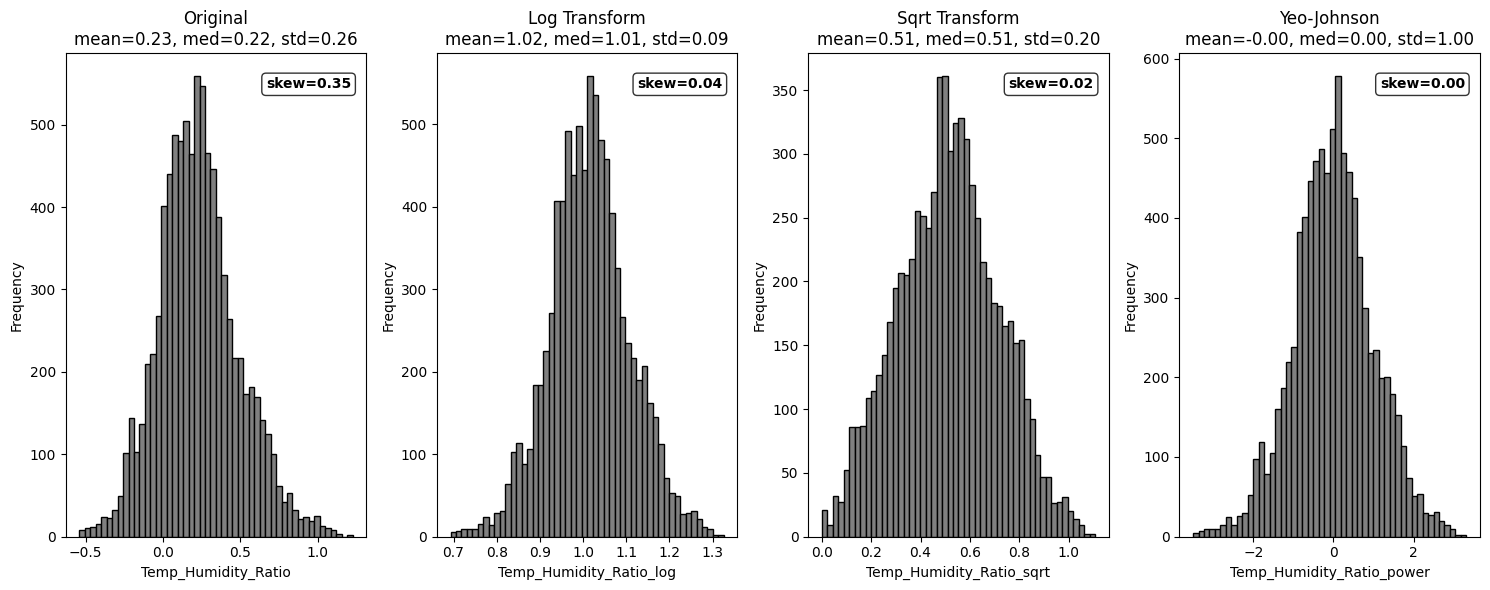

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


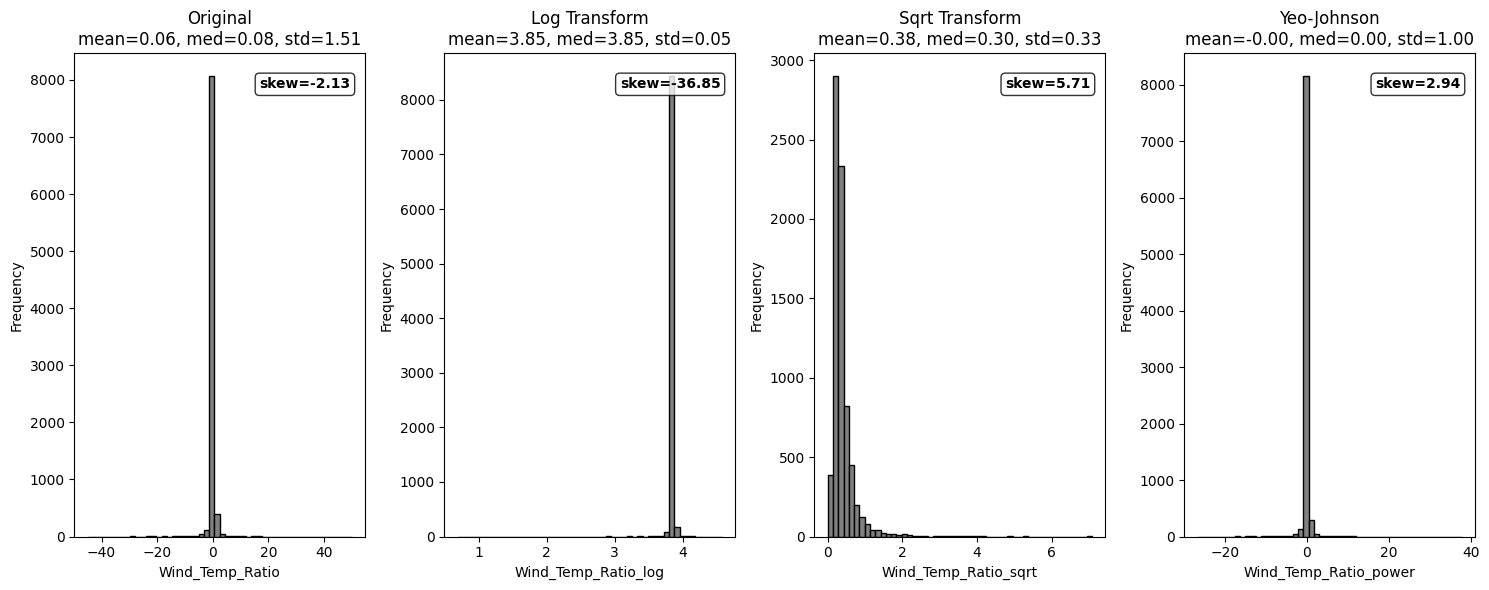

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


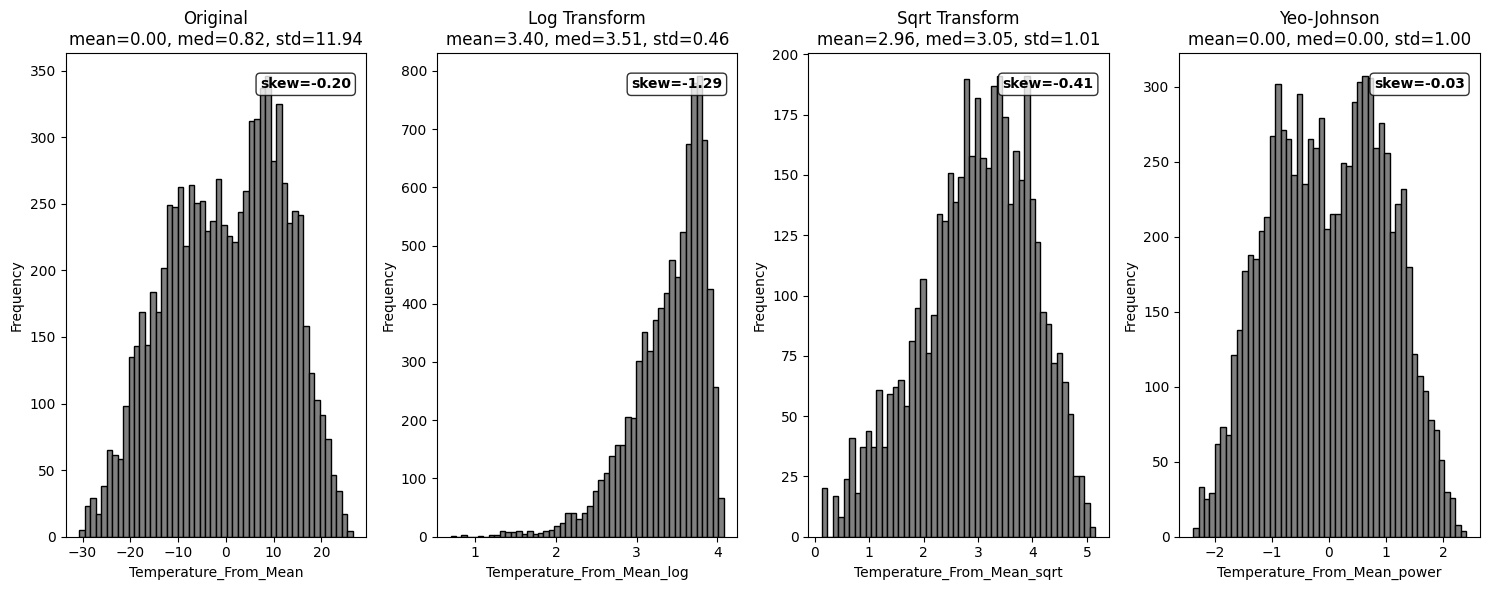

In [590]:
# Normalized/Ratio Features

# Temperature relative to humidity
df_floridabikerentals_new['Temp_Humidity_Ratio'] = df_floridabikerentals_new['Temperature(C)'] / df_floridabikerentals_new['Humidity(%)']

# Wind chill factor (simplified)
df_floridabikerentals_new['Wind_Temp_Ratio'] = df_floridabikerentals_new['Wind speed (m/s)'] / (df_floridabikerentals_new['Temperature(C)'] + 1)

# Difference Features - Temperature from Mean
df_floridabikerentals_new['Temperature_From_Mean'] = df_floridabikerentals_new['Temperature(C)'] - df_floridabikerentals_new['Temperature(C)'].mean()

# Transformed Features
# Apply to continuous (float64) Featres only
continuous_cols = df_floridabikerentals_new.select_dtypes(include='float64').columns.tolist()

# Make a copy of the DataFrame to test with
df_test = df_floridabikerentals_new.copy(deep=True)

# Apply power transformation using Yeo-Johnson (handles positive and negative values)
transformer = PowerTransformer(method='yeo-johnson')

# Iterate over continuous columns and compare original/transformed feature
for i, col in enumerate(continuous_cols):

    # Apply log transformation (using log1p to handle zeros)
    # Option 2: Shift data to positive before log
    # Error: ValueError: supplied range of [0.6931, inf] is not finite
    # Clean the column first
    df_test[col] = df_test[col].replace([np.inf, -np.inf], np.nan)
    df_test[col] = df_test[col].fillna(df_test[col].median())

    # Now transform
    min_val = df_test[col].min()
    df_test[f'{col}_log'] = np.log1p(df_test[col] - min_val + 1)
    #df_test[f'{col}_log'] = np.log1p(df_test[col])

    # Apply square root transformation
    df_test[f'{col}_sqrt'] = np.sqrt(df_test[col])

    # Fit and transform
    # Error: ValueError: Input X contains infinity or a value too large for dtype('float64').
    # Remove infinit Values
    df_test[col] = df_test[col].replace([np.inf, -np.inf], np.nan)
    df_test[col] = df_test[col].fillna(df_test[col].median())
    df_test[f'{col}_power'] = transformer.fit_transform(df_test[[col]])

    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(15, 6))

    # Plot Statistics in the Title
    orig_data = df_test[col]
    axes[0].set_title(f'Original\nmean={orig_data.mean():.2f}, med={orig_data.median():.2f}, std={orig_data.std():.2f}')
    axes[0].hist(df_test[col], bins=50, edgecolor='black', color='grey')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Display skew as label in the plot
    axes[0].text(0.95, 0.95, f'skew={orig_data.skew():.2f}', 
             transform=axes[0].transAxes, 
             ha='right', va='top',
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
 
    #print(f'{col}_log')
    log_data = df_test[f'{col}_log']
    axes[1].set_title(f'Log Transform\nmean={log_data.mean():.2f}, med={log_data.median():.2f}, std={log_data.std():.2f}')
    axes[1].hist(df_test[f'{col}_log'], bins=50, edgecolor='black', color='grey')
    axes[1].set_xlabel(f'{col}_log')
    axes[1].set_ylabel('Frequency')

    # Display skew as label in the plot
    axes[1].text(0.95, 0.95, f'skew={log_data.skew():.2f}', 
             transform=axes[1].transAxes, 
             ha='right', va='top',
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    sqrt_data = df_test[f'{col}_sqrt']
    axes[2].set_title(f'Sqrt Transform\nmean={sqrt_data.mean():.2f}, med={sqrt_data.median():.2f}, std={sqrt_data.std():.2f}')
    axes[2].hist(df_test[f'{col}_sqrt'], bins=50, edgecolor='black', color='grey')
    axes[2].set_xlabel(f'{col}_sqrt')
    axes[2].set_ylabel('Frequency')

    # Display skew as label in the plot
    axes[2].text(0.95, 0.95, f'skew={sqrt_data.skew():.2f}', 
             transform=axes[2].transAxes, 
             ha='right', va='top',
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))    

    power_data = df_test[f'{col}_power']
    axes[3].set_title(f'Yeo-Johnson\nmean={power_data.mean():.2f}, med={power_data.median():.2f}, std={power_data.std():.2f}')
    axes[3].hist(df_test[f'{col}_power'], bins=50, edgecolor='black', color='grey')
    axes[3].set_xlabel(f'{col}_power')
    axes[3].set_ylabel('Frequency')

    # Display skew as label in the plot
    axes[3].text(0.95, 0.95, f'skew={power_data.skew():.2f}', 
             transform=axes[3].transAxes, 
             ha='right', va='top',
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
# Free Form Features

##### <b>Choose Best Transform For Each Feature</b> #####
    Examine the skew for each Feature/Transform combination and determine the best one to use

In [591]:
def get_best_transform(df, col):
    
    results = {}
    
    # Original
    results['original'] = df[col].skew()
    
    # Log (only if all values can be made positive)
    min_val = df[col].min()
    log_data = np.log1p(df[col] - min_val + 1)
    results['log'] = log_data.skew()
    
    # Sqrt (only if all values can be made positive)
    sqrt_data = np.sqrt(df[col] - min_val + 1)
    results['sqrt'] = sqrt_data.skew()
    
    # Yeo-Johnson
    transformer = PowerTransformer(method='yeo-johnson')
    power_data = transformer.fit_transform(df[[col]]).flatten()
    results['yeo-johnson'] = pd.Series(power_data).skew()
    
    # Find best (closest to 0)
    best_transform = min(results, key=lambda k: abs(results[k]))
    
    return best_transform, results

for col in continuous_cols:
    best, all_skews = get_best_transform(df_test, col)
    print(f"{col}:")
    print(f"  Skews: {', '.join([f'{k}={v:.3f}' for k, v in all_skews.items()])}")
    print(f"  Best: {best}")
    print()

Temperature(C):
  Skews: original=-0.198, log=-1.295, sqrt=-0.657, yeo-johnson=-0.234
  Best: original

Wind speed (m/s):
  Skews: original=0.891, log=0.253, sqrt=0.445, yeo-johnson=0.001
  Best: yeo-johnson

Solar Radiation (MJ/m2):
  Skews: original=1.504, log=1.196, sqrt=1.266, yeo-johnson=0.563
  Best: yeo-johnson

Rainfall(mm):
  Skews: original=14.533, log=7.348, sqrt=9.115, yeo-johnson=3.714
  Best: yeo-johnson

Snowfall (cm):
  Skews: original=8.441, log=6.298, sqrt=6.743, yeo-johnson=4.103
  Best: yeo-johnson

Temp_Humidity_Ratio:
  Skews: original=0.346, log=0.038, sqrt=0.104, yeo-johnson=0.002
  Best: yeo-johnson

Wind_Temp_Ratio:
  Skews: original=-2.135, log=-36.850, sqrt=-15.056, yeo-johnson=2.941
  Best: original

Temperature_From_Mean:
  Skews: original=-0.198, log=-1.295, sqrt=-0.657, yeo-johnson=-0.028
  Best: yeo-johnson



##### <b>Choose and Apply Best Transform to New DataFrame</b> #####
    Temperature(C): Skews: original=-0.198 ==> Best: original - Do Nothing
    Wind speed (m/s):Skews: yeo-johnson=0.001 ==> Best: yeo-johnson
    Solar Radiation (MJ/m2): Skews: yeo-johnson=0.563 ==> Best: yeo-johnson
    Rainfall(mm): Skews:yeo-johnson=3.714 ==> Best: yeo-johnson
    Snowfall (cm): Skews: yeo-johnson=4.103 ==> Best: yeo-johnson
    Temp_Humidity_Ratio: Skews: yeo-johnson=0.002  ==> Best: yeo-johnson
    Wind_Temp_Ratio:Skews: original=-2.135 ==> Best: original - Do Nothing
    Temperature_From_Mean: Skews: yeo-johnson=-0.028 =+> Best: yeo-johnson

In [ ]:
# Apply Suggested Transforms

def ApplyYeoJohnsonTransform(df_target, col):
    # Fit and transform
    # Error: ValueError: Input X contains infinity or a value too large for dtype('float64').
    # Remove infinit Values
    df_target[col] = df_target[col].replace([np.inf, -np.inf], np.nan)
    df_target[col] = df_target[col].fillna(df_target[col].median())
    df_target[f'{col}_power'] = transformer.fit_transform(df_target[[col]])

    # Drop Original column to avoid multicollinearity
    df_target = df_target.drop(col, axis=1)

    return df_target

columns_to_transform = ['Wind speed (m/s)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 
                        'Snowfall (cm)', 'Temp_Humidity_Ratio', 'Temperature_From_Mean']

for col in columns_to_transform:
    df_floridabikerentals_new = ApplyYeoJohnsonTransform(df_floridabikerentals_new, col)
                        

KeyError: 'Solar Radiation (MJ/m2):'

### Plot the original "Dirty Data" to see distributions ###
#### Feature Distributions for Numerical Columns-- Histograms ####

In [ ]:
# The columns we want to plot:
print('Numeric Feature Columns to plot')
numeric_cols = df_NSME1988_dirty.select_dtypes(include=['number']).columns.tolist()
print(numeric_cols)

def PlotHistogramsToViewDistributions(df_dataset):
    n_cols = len(numeric_cols)
    print(f'Number of Columns: {n_cols}')

    fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
    axes = axes.flatten()

    plt.suptitle('Raw Feature Distributions - Non-Normailzed', fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top

    #Iterate over each numeric column and plot a historgram
    for i, col in enumerate(numeric_cols):
        sns.histplot(data=df_dataset, x=col, ax=axes[i], kde=True)    
        axes[i].set_title(col, fontweight='bold')

        # Calculate statistics
        mean_val = df_dataset[col].mean()
        median_val = df_dataset[col].median()
        mode_val = df_dataset[col].mode()[0] if not df_dataset[col].mode().empty else None
        std_val = df_dataset[col].std()

        # Plot Statistics as Vertical Lines
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        if mode_val is not None:
            axes[i].axvline(mode_val, color='blue', linestyle='--', linewidth=2, label=f'Mode: {mode_val:.2f}')
        
        # Add std as shaded region around mean
        axes[i].axvspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='gray', label=f'Std: {std_val:.2f}')
        
        # Add legend
        axes[i].legend(fontsize=8, loc='upper right')


    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()   


PlotHistogramsToViewDistributions(df_NSME1988_dirty)


Numeric Feature Columns to plot


NameError: name 'df_NSME1988_dirty' is not defined

##### Histogram Analysis #####
    1. The following columns' distribution is right skewed (indicating the presence of outliers).
        This will have to be fixed via cropping as we seek a more normalized distribution.
        visits      
        nvisits     
        ovisits     
        novisits    
        emergency   
        hospital    
        chronic     
        age         
        school      
        income       
        insurance
    2. Age does not follow this pattern. It looks like a more normal or bimodal distribution.


#### Box Plots for Numerical Columns-- Identify Outliers ####

In [ ]:

def PlotBoxPlotsToViewDistributions(df_dataset):
    n_cols = len(numeric_cols)

    fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
    axes = axes.flatten()

    plt.suptitle('Raw Feature Distributions - Box Plots', fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top

    #Iterate over each numeric column and plot a historgram
    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df_dataset, y=col, ax=axes[i])    
        axes[i].set_title(col, fontweight='bold')

        # Optional: Add count of outliers
        Q1 = df_dataset[col].quantile(0.25)
        Q3 = df_dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_count = len(df_dataset[(df_dataset[col] < lower) | 
                                            (df_dataset[col] > upper)])
        axes[i].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                    transform=axes[i].transAxes, ha='center', fontsize=9, fontweight='bold')

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()   

PlotBoxPlotsToViewDistributions(df_NSME1988_dirty)

##### BoxPlot Analysis #####
    1. The boxplots reinforce the histograms results, indicating outliers in the higher values (which relate to right skewedness).
    The outliers indicate a high volume of outliers (lots of circles above the box).
    The boxes for most of them look pretty small which indicates the median is close to zero (0).
    It looks like healthcare resources aren't heavily used.
        visits      
        nvisits     
        ovisits     
        novisits    
        emergency   
        hospital    
        chronic     
        age         
        school      
        income       
        insurance
    2. School looks like it's got some outliers at the lower values, which would point to a left skew with some lower valued outliers.
       I don't think we want to fix (crop) this because lower education could very well be a predicator and have some significance.


In [ ]:
# Examine value ranges for numeric columns
#

summary = pd.DataFrame()

for i, col in enumerate(numeric_cols):
    summary = df_NSME1988_dirty[numeric_cols].describe().loc[['min', '25%', '50%', '75%', 'max']]
    
print(summary)

sns.heatmap(df_NSME1988_dirty.isnull(), cbar=False, yticklabels=False)
plt.show()

##### Range Analysis #####
    1. We have some bad/incorrect data with the following columns registering a count 0f -1 (You can't have -1 visits)
        visits      
        nvisits     
        ovisits     
        novisits    
    2. The following columns look suspect because 3/4 of their quantiles are showing 0 with values skewed to max
        emergency
        hospital
    3. I can do a heatmap to show the missing data in the dataframe (numeric columns).
    The heatmap is a plot of missing data in the numeric columns. Visually it looks like we have a fair amount of missing data.

In [ ]:
#
# grubbs_test - Found this on internet when searching for methods
#
#
def grubbs_test(data):
    """
    Performs Grubbs' test for outliers on a dataset
    Tests if the most extreme value is an outlier
    
    Returns: G statistic and p-value
    """
    # Remove NaN values
    data = data.dropna()
    
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    
    # Calculate G statistic (max deviation from mean in std units)
    G = np.max(np.abs(data - mean)) / std
    
    # Calculate p-value using t-distribution
    t_stat = G * np.sqrt(n-2) / np.sqrt(n-1-G**2)
    p_value = 2 * (1 - t.cdf(abs(t_stat), n-2))
    
    return G, p_value


def run_grubbs_test():
    # Print skewness
    for col in numeric_cols:
        print(f"{col}: Skewness: {df_NSME1988_dirty[col].skew():.2f}")

    print()
    print('----------------------------------------------------------')
    print()

    for col in numeric_cols:
        print(f"\n{'='*60}")
        print(f"Column: {col}")
        print(f"{'='*60}")
        
        # Original skewness
        orig_skew = df_NSME1988_dirty[col].skew()
        print(f"Original skewness: {orig_skew:.2f}")
        
        # Log transform (log1p handles zeros)
        log_data = np.log1p(df_NSME1988_dirty[col].dropna())
        log_skew = stats.skew(log_data)
        print(f"Log-transformed skewness: {log_skew:.2f}")
        
        # Now apply Grubbs test on transformed data
        if abs(log_skew) < 1:  # Check if transformation worked
            G, p_val = grubbs_test(log_data)
            print(f"Grubbs G-statistic: {G:.4f}")
            print(f"P-value: {p_val:.4f}")
            
            if p_val < 0.05:
                print("Conclusion: Significant outlier detected (p < 0.05)")
            else:
                print("Conclusion: No significant outlier (p ≥ 0.05)")
        else:
            print("Still too skewed even after log transformation")


run_grubbs_test()

##### Prove/Disprove which numeric columns contain outliers ######
    We want to provide some statisical analysis that proves whether the data truly contains extreme outliers (data errors) or the values are
    are within within legitmate ranges.

    The data is heavily right skewed. So we can't directly apply Z-Score, so I did some research and found a custom implementation of grubbs_test()
    which returns the max deviation from the mean and a p_value.

    Data is too skewed, so we first applied log transformation in order to make the distribution more normal. 
    This stil didn't work particularly well as all the columns (except for chronic) were too skewed.
    For 'chronic' we got a P-Value of 0.0088 (p < 0.05) indicating it detected an outlier.

    To try to overcome this, I will try additional (Power) transformations:
        - Square root transformation
        - Yeo-Johnson transformation 
        - Box-Cox transformation  - Since we have negative values we won't use Box-Cox

In [ ]:
# Store the results in a data frame
results = pd.DataFrame(columns=['Original', 'Square Root', 'Yeo-Johnson'])

for col in numeric_cols:
    
    original = df_NSME1988_dirty[col].dropna()
    
    # Apply transformations
    sqrt_data = np.sqrt(original)
    yeojohnson_data, _ = yeojohnson(original)
    
    # Store skewness values
    results.loc[col] = [
        original.skew(),
        sqrt_data.skew(),
        pd.Series(yeojohnson_data).skew()
    ]

print('Results of applying Power Transforms')
print('-----------------------------------------')
print(results)

##### Analysis of Applied Transformations #####
    Based on the results of applying sqrt and Yeo-Johnson:

                    Original   Square Root  Yeo-Johnson
        visits      3.611181     0.616842    -0.013211
        nvisits     7.538863     2.533991    -0.417325
        ovisits    19.561863     3.759981    -1.306321
        novisits   23.646347     5.781900    -1.614963
        emergency   5.040876     2.066182     1.638413
        hospital    3.971046     1.956877     1.525857
        chronic     1.012530    -0.321434    -0.012175
        age         7.413582     6.466510     0.000000
        school     -0.453236    -1.905147    -0.109121
        income      5.813436     1.787623    -0.098247

    It looks like Yeo-Johnson transformation provided the best results.
    The p-values look much more reasonable.

##### Plot the results of Yeo-Johnson Transformation #####


In [ ]:
#
# Plot original and  Yeo-Johnson transformation to all the numeric columns
#


n_rows = len(numeric_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 5 * n_rows))
axes = axes.flatten()

plt.suptitle('Original vs Yeo-Johnson Transformations', fontweight='bold', fontsize=16)

# Iterate over each numeric column
plot_idx = 0
for col in numeric_cols:
    # Original data
    original = df_NSME1988_dirty[col].dropna()
    
    # ORIGINAL PLOT
    sns.histplot(data=df_NSME1988_dirty, x=col, ax=axes[plot_idx], kde=True)    
    axes[plot_idx].set_title(f'{col} - Original', fontweight='bold')

    # Calculate statistics for original
    mean_val = original.mean()
    median_val = original.median()
    mode_val = original.mode()[0] if not original.mode().empty else None
    std_val = original.std()

    # Plot Statistics as Vertical Lines
    axes[plot_idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[plot_idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    if mode_val is not None:
        axes[plot_idx].axvline(mode_val, color='blue', linestyle='--', linewidth=2, label=f'Mode: {mode_val:.2f}')
    
    # Add std as shaded region around mean
    axes[plot_idx].axvspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='gray', label=f'Std: {std_val:.2f}')
    axes[plot_idx].legend(fontsize=8, loc='upper right')
    
    plot_idx += 1
    
    # YEO-JOHNSON TRANSFORMED PLOT
    yeojohnson_data, yj_lambda = yeojohnson(original)
    yj_series = pd.Series(yeojohnson_data)
    
    sns.histplot(yj_series, ax=axes[plot_idx], kde=True, color='red')
    axes[plot_idx].set_title(f'{col} - Yeo-Johnson (λ={yj_lambda:.2f}, skew={yj_series.skew():.2f})', fontweight='bold')
    
    # Calculate statistics for transformed
    mean_yj = yj_series.mean()
    median_yj = yj_series.median()
    mode_yj = yj_series.mode()[0] if not yj_series.mode().empty else None
    std_yj = yj_series.std()
    
    # Plot Statistics as Vertical Lines
    axes[plot_idx].axvline(mean_yj, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_yj:.2f}')
    axes[plot_idx].axvline(median_yj, color='green', linestyle='--', linewidth=2, label=f'Median: {median_yj:.2f}')
    if mode_yj is not None:
        axes[plot_idx].axvline(mode_yj, color='blue', linestyle='--', linewidth=2, label=f'Mode: {mode_yj:.2f}')
    
    # Add std as shaded region around mean
    axes[plot_idx].axvspan(mean_yj - std_yj, mean_yj + std_yj, alpha=0.2, color='gray', label=f'Std: {std_yj:.2f}')
    axes[plot_idx].legend(fontsize=8, loc='upper right')
    
    plot_idx += 1

# Hide any unused subplots
for idx in range(plot_idx, len(axes)):
    axes[idx].set_visible(False)

# Make plots more readable and add space
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# 
# grubbs_test for transformed data
#
def run_grubbs_test_for_transformed_data():

    # Run Grubbs test on transformed data
    for col in numeric_cols:
        print(f"\n{'='*60}")
        print(f"Column: {col}")
        print(f"{'='*60}")
        
        # Get original data
        original = df_NSME1988_dirty[col].dropna()
        
        # Apply Yeo-Johnson transformation
        yeojohnson_data, yj_lambda = yeojohnson(original)
        yj_series = pd.Series(yeojohnson_data)
        
        # Check if transformation improved normality
        orig_skew = original.skew()
        yj_skew = yj_series.skew()
        
        print(f"Original skewness: {orig_skew:.2f}")
        print(f"Transformed skewness: {yj_skew:.2f}")
        print(f"Lambda: {yj_lambda:.2f}")
        
        # Run Grubbs test on transformed data
        if abs(yj_skew) < 1:  # Reasonably normal
            G, p_val = grubbs_test(yj_series)
            print(f"\nGrubbs Test Results:")
            print(f"  G-statistic: {G:.4f}")
            print(f"  P-value: {p_val:.4f}")
            
            if p_val < 0.05:
                print(f"  ✓ Significant outlier detected (p < 0.05)")
            else:
                print(f"  ✗ No significant outlier detected (p ≥ 0.05)")
        else:
            print(f"\n⚠ Still too skewed (|{yj_skew:.2f}| >= 1) for reliable parametric test")


#
# Rerun Initial grubbs_test
#

run_grubbs_test_for_transformed_data()

## <u>**2. Data Wrangling**</u> ##

### Clean Up Missing Data Issues ###
    In our case we've previously identified that the columns with missing data are of type float.
    We want to determine which data replacement strategy works best with our data.
    We have the following replacement techniques available to us:
- **Mean imputation**: Replace missing values with the column mean
- **Median imputation**: Replace missing values with the column median
- **KNN imputation**: Use K-Nearest Neighbors to estimate missing values
- **Iterative imputation**: Model each feature as a function of others (MICE algorithm)

## ##
    What we really want to do is apply the different techniques and then determine which one works best for our needs.
    We could do this 2 ways:
- **Apply the same method for the desired columns** </br>
(Simpler/Faster)
- **Iterate through the columns one by one to determine what is best for each column** </br>
(More Precise, but doesn't make sense for all strategies - KNN/Mice use other columns)

## ##
    For expediency and simplification purposes, we will use the same missing data replacement technique across columns.

    To find the best technique, we must test against known data. 
    To that end, we'll create a sample data set void of rows with missing data.
    We'll make a copy of that data set (A). Next we'll making a second data set A and randomly
    create missing values across the columsn of interest.
    Then we will run our selected replacement strategies capturing the results (with missing data replaced).
    We then compare our original sample (A) against the modified samples and determine which technique works best.


##### Filter out existing rows with missing data - create dataset copy with manufactured missing rows#####

In [ ]:
#
# Count the number of "complete/clean" rows of data and number of rows that have missing data
#

columns_with_missing_data = ['visits','nvisits','ovisits','novisits','emergency',
                            'hospital','chronic','age','school','income']
complete_rows = df_NSME1988_dirty[columns_with_missing_data].dropna()
rows_with_missing_data = df_NSME1988_dirty[df_NSME1988_dirty[columns_with_missing_data].isnull().any(axis=1)]

print(f"Complete rows: {len(complete_rows)}")
print(f"Rows with missing data: {len(rows_with_missing_data)}")


# Create artificial missingness
test_data = complete_rows.copy()
np.random.seed(42)
missing_mask = np.random.random(test_data.shape) < 0.10
true_values = test_data.values[missing_mask]
test_data.values[missing_mask] = np.nan

# Test all methods
results = {}

print(df_NSME1988_dirty.head(20))

# Mean (all columns)
mean_imp = SimpleImputer(strategy='mean')
results['Mean'] = mean_absolute_error(true_values, mean_imp.fit_transform(test_data)[missing_mask])

# Median (all columns)
median_imp = SimpleImputer(strategy='median')
results['Median'] = mean_absolute_error(true_values, median_imp.fit_transform(test_data)[missing_mask])

# KNN (uses relationships between columns)
knn_imp = KNNImputer(n_neighbors=5)
results['KNN'] = mean_absolute_error(true_values, knn_imp.fit_transform(test_data)[missing_mask])

# MICE (uses relationships between columns)
mice_imp = IterativeImputer(random_state=42)
results['MICE'] = mean_absolute_error(true_values, mice_imp.fit_transform(test_data)[missing_mask])

# Winner
print('---------------------------------------------------------')
print('Imputation Results')
print(results)
print('--------------------------------------------------------')
best = min(results, key=results.get)
print(f"Best method: {best}")

#
# For additional analysis, let's run the imputations and plot results against originals
#

df_mean = df_NSME1988_dirty.copy()
df_median = df_NSME1988_dirty.copy()

for col in columns_with_missing_data:

    # Mean Imputation
    df_mean.fillna({col: df_mean[col].mean()}, inplace=True)

    # Median Imputation
    df_median.fillna({col: df_median[col].median()}, inplace=True)

# KNN Imputation (all columns at once)
knn_imputer = KNNImputer(n_neighbors=5)
knn_array = knn_imputer.fit_transform(df_NSME1988_dirty[columns_with_missing_data])

# Convert entire result to DataFrame
df_knn = pd.DataFrame(
    knn_array,
    columns=columns_with_missing_data,
    index=df_NSME1988_dirty.index
)    

# Iterative Imputation
iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
iterative_array = iterative_imputer.fit_transform(df_NSME1988_dirty[numeric_cols])

# Convert back to DataFrame
df_iterative = pd.DataFrame(
    iterative_array,
    columns=numeric_cols,
    index=df_NSME1988_dirty.index
)


n_rows = len(columns_with_missing_data)

fig, axes = plt.subplots(nrows=n_rows, ncols=4, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Define imputation methods and their properties
imputation_methods = [
    {'data': df_mean, 'title': 'Mean Imputation', 'color': 'green', 'label': 'Mean Imputed'},
    {'data': df_median, 'title': 'Median Imputation', 'color': 'orange', 'label': 'Median Imputed'},
    {'data': df_knn, 'title': 'KNN Imputation', 'color': 'purple', 'label': 'KNN Imputed'},
    {'data': df_iterative, 'title': 'Iterative Imputation', 'color': 'teal', 'label': 'Iterative Imputed'}
]

pltIdx = 0

for col in columns_with_missing_data:

    # Create KDE of original distribution
    kde_original = stats.gaussian_kde(df_NSME1988_dirty[col].dropna())
    x_range = np.linspace(df_NSME1988_dirty[col].min(), df_NSME1988_dirty[col].max(), 200)
    kde_values = kde_original(x_range)

    # Plot each imputation method
    for method in imputation_methods:

        ax = axes[pltIdx]
        ax.set_title(method['title'])

        ax.hist(
            method['data'][col],
            bins=30, density=True,
            edgecolor='black', color=method['color'],
            label=method['label']
        )

        ax.plot(
            x_range, kde_values,
            'b-', linewidth=2.5,
            label='Original Distribution'
        )

        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.legend(loc='upper right')

        pltIdx += 1

# Hide any unused subplots
for idx in range(plot_idx, len(axes)):
    axes[idx].set_visible(False)

# Make plots more readable and add space
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



#### Imputation Analysis Results ####
    Basing decision on visual analysis of Imputation vs Original plots is difficult due to the skewedness of the data.
    We have to rely on Mean Absolute Error (MAE) calculations for each of the Imputation types
    
**Imputation Results** </br>
        Median: 1.4677338374016535 </br>
        MICE:   1.6830630938567108</br>
        KNN:    1.680683066185563 </br>
        Mean:   1.7257226749105237 </br>

**Median Imputation** had the lowest MAE and is the clear winner.
## ##
    Apply Median Imputation to the numeric columns with missing data.
    Then test to see if we have any remaining columns with missing data.


In [ ]:
#
# Replace numeric columns with missing data in the original data set with imputated values
#
df_NSME1988_dirty_new[columns_with_missing_data] = df_median[columns_with_missing_data]

# See if we have any remaining columns with missing data
# Verify no missing values remain
missing_data_column_count = df_NSME1988_dirty_new[columns_with_missing_data].isnull().sum().sum()
print(f'Number of columns with missing data: {missing_data_column_count}')

if missing_data_column_count > 0:
    print('We still have the following columns with missing data:')
    print(df_NSME1988_dirty_new.isnull().sum()[df_NSME1988_dirty_new.isnull().sum() > 0])
else:
    print('We have cleaned up all the missing data in the dataset')

### Handle Negative Values ###
    In our data set, negative values are not valid. 
    They are more than likely data errors.
    The best way to handle them is to replace them with zeros (0)

In [ ]:
#
# Replace negative values with zeros
#

cols_with_negatives = [col for col in numeric_cols if (df_NSME1988_dirty_new[col] < 0).sum() > 0]
print(f"\nTotal columns with negative values: {len(cols_with_negatives)}")
print(f'Columns with Negative Values are {cols_with_negatives}')

for col in numeric_cols:
    negative_count = (df_NSME1988_dirty_new[col] < 0).sum()
    if negative_count > 0:
        print(f"{col}: {negative_count} negative values found, replacing with 0")
        df_NSME1988_dirty_new[col] = df_NSME1988_dirty_new[col].clip(lower=0)

print()
print('Normalization of negative values completed')
cols_with_negatives = [col for col in numeric_cols if (df_NSME1988_dirty_new[col] < 0).sum() > 0]
print(f"\nTotal columns with negative values: {len(cols_with_negatives)}")

### "Normalize" Age and Income Columns to have realistic values
    After some investigation and thought about 'age' and 'income', I was able to come to some assumptions.
    If I multiply 'age' by a factor of 10, I get what look like some reasonable numbers.
    Income was a little harder to figure out. After trying different strategies and looking at the resulting ranges,
    to me it looks like income is really 'monthly income', not 'yearly income'.

In [ ]:
# Mulitply Age by 10 to get true age in years
df_NSME1988_dirty_new['age'] = df_NSME1988_dirty_new['age'] * 10

# Mulitply Income by 1000 to get true value
df_NSME1988_dirty_new['income'] = df_NSME1988_dirty_new['income'] * 1000

print('------------------Modified Data--------------------')
print(df_NSME1988_dirty_new[['age','income']].describe().T)
print('--------------------------------------')
print()

### Reanalyze and ID and Examine Potential Outliers ###

In [ ]:
# Replot Histograms and BoxPlots for dataframe with corrected Missing Values

PlotHistogramsToViewDistributions(df_NSME1988_dirty_new)

PlotBoxPlotsToViewDistributions(df_NSME1988_dirty_new)

#### We still see Right Skewed Distrbutions with Extreme Outliers ####
    The next step is to analytically quanitfy the existance of outliers on the numeric columns
    We will use the following methods, then visualize the results across the different column types:
- **IQR method**: Use interquartile range (Q3 - Q1) to identify outliers
- **Z-score method**: Identify values more than 3 standard deviations from the mean
- **Isolation Forest**: Machine learning algorithm that isolates anomalies
- **Local Outlier Factor (LOF)**: Density-based method comparing local density to neighbors    

In [ ]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    """
    Detect outliers using the IQR method.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - multiplier: IQR multiplier (typically 1.5 for outliers, 3.0 for extreme outliers)
    
    Returns:
    - Boolean series indicating outliers
    """

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    
    return outliers

# Sample Call:
# outliers_iqr = detect_outliers_iqr(df_original, outlier_feature)

def detect_outliers_zscore(data, column, threshold=3):
    """
    Detect outliers using the Z-Score method.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - threshold: z-score threshold (typically 3)
    
    Returns:
    - Boolean series indicating outliers
    """

    mean = data[column].mean()
    std = data[column].std()
    z_scores = np.abs((data[column] - mean) / std)
    
    outliers = z_scores > threshold
    
    return outliers

# Sample Call
#outliers_zscore = detect_outliers_zscore(df_original, outlier_feature)

def detect_outliers_isolation_forest(data, column, contamination=0.05):
    """
    Detect outliers using Isolation Forest.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - contamination: expected proportion of outliers (default 0.05 = 5%)
    
    Returns:
    - Boolean series indicating outliers
    """
    # Isolation Forest requires 2D array
    X = data[[column]].values
    
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    predictions = iso_forest.fit_predict(X)
    
    # Isolation Forest returns -1 for outliers, 1 for inliers
    outliers = predictions == -1
    
    return outliers

# Sample Call
#outliers_iforest = detect_outliers_isolation_forest(df_original, outlier_feature)

def detect_outliers_lof(data, column, n_neighbors=1000, contamination=0.05):
    """
    Detect outliers using Local Outlier Factor.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - n_neighbors: number of neighbors to consider (default 1000)
    
    Returns:
    - Boolean series indicating outliers
    """

    # LOF requires 2D array
    X = data[[column]].values
    
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    predictions = lof.fit_predict(X)
    
    # LOF returns -1 for outliers, 1 for inliers
    outliers = predictions == -1

    return outliers

# Sample Call
# outliers_lof = detect_outliers_lof(df_original, outlier_feature)

# Iterate over all the numeric columns and gather/store Outlier information across our 4 methods

outlier_results = []

for col in numeric_cols:

    outliers_iqr = detect_outliers_iqr(df_NSME1988_dirty_new, col)
    outliers_zscore = detect_outliers_zscore(df_NSME1988_dirty_new, col)
    outliers_iforest = detect_outliers_isolation_forest(df_NSME1988_dirty_new, col)
    outliers_lof = detect_outliers_lof(df_NSME1988_dirty_new, col)

    outlier_results.append({'column_name':col, 
                            'IQR': outliers_iqr,
                            'Z-Score': outliers_zscore,
                            'IForest':outliers_iforest,
                            'LOF': outliers_lof} )

print('----------------Outlier Results-----------------')
print(outlier_results)    
print(f'Outlier Length: {len(outlier_results)}')
print('---------------------------------')
print()


#### Plot the Outlier Detection Results for Comparison ####

In [ ]:
#
# Plot the Outlier Test Results
#

colIdx=0
for col in numeric_cols:
    
    # Detect outliers for this column
    outliers_iqr = outlier_results[colIdx]['IQR']
    outliers_zscore = outlier_results[colIdx]['Z-Score']
    outliers_iforest = outlier_results[colIdx]['IForest']
    outliers_lof = outlier_results[colIdx]['LOF']
    colIdx += 1
    
    # Precompute bins
    hist_bins = np.linspace(df_NSME1988_dirty_new[col].min(), df_NSME1988_dirty_new[col].max(), 31)
    
    # Create figure for THIS column
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(f'Outlier Detection: {col}', fontsize=16, fontweight='bold')
    gs = GridSpec(4, 2, figure=fig, width_ratios=[4, 1], hspace=0.4, wspace=0.05)
    
    detection_methods = [
        {'outliers': outliers_iqr, 'title': 'IQR Method'},
        {'outliers': outliers_zscore, 'title': 'Z-Score Method'},
        {'outliers': outliers_iforest, 'title': 'Isolation Forest'},
        {'outliers': outliers_lof, 'title': 'Local Outlier Factor'}
    ]
    
    for idx, method in enumerate(detection_methods):
        outliers = method['outliers']
        
        # Scatter plot
        ax_scatter = fig.add_subplot(gs[idx, 0])
        ax_scatter.set_title(f"{method['title']}: {outliers.sum()} outliers detected")
        
        ax_scatter.scatter(
            df_NSME1988_dirty_new.index[~outliers], 
            df_NSME1988_dirty_new.loc[~outliers, col],
            c='teal', alpha=0.5, s=5
        )
        ax_scatter.scatter(
            df_NSME1988_dirty_new.index[outliers], 
            df_NSME1988_dirty_new.loc[outliers, col],
            c='orange', alpha=0.7, s=5, label='Outliers'
        )
        ax_scatter.legend(loc='lower left', framealpha=1, markerscale=3)
        
        # Histogram
        ax_hist = fig.add_subplot(gs[idx, 1], sharey=ax_scatter)
        ax_hist.hist(df_NSME1988_dirty_new.loc[~outliers, col], 
                     bins=hist_bins, 
                     orientation='horizontal', color='teal', 
                     alpha=0.7, edgecolor='black')
        
        ax_hist.hist(df_NSME1988_dirty_new.loc[outliers, col], 
                     bins=hist_bins,
                     orientation='horizontal', color='orange', 
                     edgecolor='black')
        ax_hist.tick_params(labelleft=False)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}\n")  # Visual break between columns

#### Examine Binning of Income ####
    I want to view the income feature binned to see the distribution clearer and eliminate effect of outliers/noise
    I only want to observe this and not include it in my modified datafraem. I want to work with continious variable for income there.

In [ ]:
#
# Bin Income
#

# Create temporary dataframe
df_income = df_NSME1988_dirty_new.copy()

# Bin income into 5 categories
df_income['income_group'] = pd.cut(
                                    df_income['income'],
                                    bins=5,
                                    labels=['Low', 'Low-Middle', 'Middle', 'Middle-High', 'High']
                                )

# Check the distribution
print(df_income['income_group'].value_counts())

# Plot countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_income, x='income_group', 
              order=['Low', 'Low-Middle', 'Middle', 'Middle-High', 'High'],
              palette='viridis')
plt.title('Income Distribution by Category', fontweight='bold')
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Income Binning Analysis ####
    After binning income into appropriate bins and displaying results in a count plot,
    we see the data definitely has a strong Right Skew. Most people fall into the "Low" income category.
    This is probably due to the nature of sample set (older population) - fixed income, retired.
    We don't want to lose the data for the higher income levels because it could definitely be an indicator of overall health.

#### Additional Adjustments - Age ####
    Age looks like it has data errors - no one is 400 years old.
    To resolve, decide on a reasonable max and adjust anything above it

In [ ]:
max_valid_age = 110

# Calculate median of valid ages only
valid_median = df_NSME1988_dirty_new.loc[df_NSME1988_dirty_new['age'] <= max_valid_age, 'age'].median()
df_NSME1988_dirty_new.loc[df_NSME1988_dirty_new['age'] > max_valid_age, 'age'] = valid_median


#### Outlier Detection Analysis ####
    Age, Education and Chronic - it doesn't make sense to cap() or remove as they seem like they could be valid indicators
    Apply Winsorization (capping) to the remaining columns.
    After further examination, income still seems to be a bit of a mystery. 
        - What is the real multiplication factor?
        - Should I really be working to make it an absolute dollar value for readability?
        - Should I really be capping it? Is binning more appropriate?
    It feels like if I were to continue to work on this dataset, I'd continue to tinker with the income feature (or not).


In [ ]:
#
# Cap the data
#

# Cap at 5th and 95th percentiles
def cap_outliers(data, column, lower_pct=0.05, upper_pct=0.95):
    lower = data[column].quantile(lower_pct)
    upper = data[column].quantile(upper_pct)
    data[column] = data[column].clip(lower, upper)
    return data

columns_to_be_capped = ['visits', 'nvisits', 'ovisits', 'novisits', 'emergency', 'hospital', 'income']

print('------------------Before Modificaton--------------------')
print(df_NSME1988_dirty_new[['age','income']].describe().T)
print('--------------------------------------')
print()

for col in columns_to_be_capped:
    df_NSME1988_dirty_new = cap_outliers(df_NSME1988_dirty_new.copy(), col)

print('------------------Modified Data--------------------')
print(df_NSME1988_dirty_new[['age','income']].describe().T)
print('--------------------------------------')
print()


print('Plot to see if changes affected distributions')
PlotHistogramsToViewDistributions(df_NSME1988_dirty_new)
PlotBoxPlotsToViewDistributions(df_NSME1988_dirty_new)


#### Re-examine Descriptive Statistics of Modifed Dataset ####

In [ ]:

def DisplayDescriptiveStats(dataset, columns_to_display=None):
    # Print Stats
    print("***********************************")
    print("Description Stats of Modified Dataset")
    print("***********************************")
    print()
    if columns_to_display is None:
        print(dataset.describe(include='all').T)
    else:
        print(dataset[columns_to_display].describe().T)
    print()

    # Print df Column Info
    print("***********************************")
    print("Basic Info of Modified DataSet")
    print("***********************************")
    print()
    dataset.info()
    print()
    print()

    print("***********************************")
    print("First 20 rows of Data")
    print("***********************************")
    print()
    print(dataset.head(20))
    print()


DisplayDescriptiveStats(df_NSME1988_dirty_new)

## <u>**3. Feature Engineering**</u> ##
### Feature Encoding ###
#### One-Hot Encoding ####
    Several features - Health and Region - Models like working with numbers
    Gender - currently only 2 choices (based on dataset), but make it One-Hot encoded should it change
#### Ordinal Encoding ####
    ADL is really what we are trying to predict with this model. 
    It doesn't make sense to Hot-Encode, but it does to Ordinal Encode it.
    That way we'll be able tp plot/observe correlations between our dependent/independent variables.
    (Models like working with numbers).

In [ ]:
# 
# One-Hot Encoding
#

# Use the nominal categorical variable (region)
# Apply one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Convert Region
onehot_array = encoder.fit_transform(df_NSME1988_dirty_new[['region']])

# Create dataframe with proper column names
df_onehot = pd.DataFrame(
    onehot_array,
    columns=encoder.get_feature_names_out(['region']),
    index=df_NSME1988_dirty_new.index
)

# Join back to original and drop original column
df_NSME1988_dirty_new = pd.concat([df_NSME1988_dirty_new, df_onehot], axis=1)

# Don't drop region so we can use it when we create our multi column features
# df_NSME1988_dirty_new = df_NSME1988_dirty_new.drop('region', axis=1)

# gender
onehot_array = encoder.fit_transform(df_NSME1988_dirty_new[['gender']])

# Create dataframe with proper column names
df_onehot = pd.DataFrame(
    onehot_array,
    columns=encoder.get_feature_names_out(['gender']),
    index=df_NSME1988_dirty_new.index
)

# Join back to original and drop original column
df_NSME1988_dirty_new = pd.concat([df_NSME1988_dirty_new, df_onehot], axis=1)
df_NSME1988_dirty_new = df_NSME1988_dirty_new.drop('gender', axis=1)

# adl
print(f'ADL Values:{df_NSME1988_dirty_new['adl'].unique()}')

# Apply ordinal encoding for adl
categories = [['limited', 'normal']]
encoder = OrdinalEncoder(categories=categories)
df_NSME1988_dirty_new['adl'] = encoder.fit_transform(df_NSME1988_dirty_new[['adl']])

# health
print(f'Health Values:{df_NSME1988_dirty_new['health'].unique()}')

# Apply ordinal encoding for adl
categories = [['poor', 'average', 'excellent']]
encoder = OrdinalEncoder(categories=categories)
df_NSME1988_dirty_new['health'] = encoder.fit_transform(df_NSME1988_dirty_new[['health']])

# Stats for Altered DataFrame
print('DataFrame with One-Hot and Ordinal Encoding Modifications')
DisplayDescriptiveStats(df_NSME1988_dirty_new)

#### Label Encoding ####
    Several features - Employed, Insurance, Medicaid, Married


In [ ]:
le = LabelEncoder()

# Apply to each column
df_NSME1988_dirty_new['employed'] = le.fit_transform(df_NSME1988_dirty_new['employed'])
df_NSME1988_dirty_new['married'] = le.fit_transform(df_NSME1988_dirty_new['married'])
df_NSME1988_dirty_new['insurance'] = le.fit_transform(df_NSME1988_dirty_new['insurance'])
df_NSME1988_dirty_new['medicaid'] = le.fit_transform(df_NSME1988_dirty_new['medicaid'])

# Stats for Altered DataFrame
print('DataFrame with Label Encoding Modifications')
DisplayDescriptiveStats(df_NSME1988_dirty_new)

#### Data Type Conversion ####
    After looking over all the numeric columns (including the new ones generated through encoding),
    I was able to convert all the existing floating point variables into integers.
    Given their lower value ranges, a majority of them were convertered to int8.
    Income was converted to int32 to accomodate it's high ceiling. For our analysis purposed,
    we don't really care about "cents" values, whole dollars is more appropriate

In [ ]:
# Int64 to Int16 conversions
int8_conversion_columns = [ 'visits','nvisits','ovisits','novisits','emergency','hospital','chronic','age', 
                            'school','region_northeast','region_other','region_west','gender_male']

int32_conversion_columns = [ 'income']

df_NSME1988_dirty_new[int8_conversion_columns] = df_NSME1988_dirty_new[int8_conversion_columns].astype('int8')
df_NSME1988_dirty_new[int32_conversion_columns] = df_NSME1988_dirty_new[int32_conversion_columns].astype('int32')

# Stats for Altered DataFrame
print('DataFrame with Data Type Conversions')
DisplayDescriptiveStats(df_NSME1988_dirty_new)

#### Create Correlation Matrix for Feature Analysis ####
    Create a correlation matrix to look for relationships between freature variables

In [ ]:
#
# Examine Correlation
#


# omit categorical column region
corr = df_NSME1988_dirty_new.drop(columns=['region']).corr()
# print(type(corr))
# print(corr)

# Create heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print()
print()

# Table

plt.figure(figsize=(14, 8))
plt.axis('off')
table = plt.table(
    cellText=corr.round(2).values,
    rowLabels=corr.index,
    colLabels=corr.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(1.2, 1.8)
plt.title('Correlation Table', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()



#### Create Combined Features #####
    Create some combined features that make sense given the dataset:
        - total vistis - I'm assuming that existing 'visits' is not the total number of visits
        so I include it in my total number of visits (needs clarifcation)
        - total visits per region

In [ ]:
# 
# Multi feature columns by hand
#

# Total Visits
df_NSME1988_dirty_new['total_visits'] = df_NSME1988_dirty_new['visits'] + df_NSME1988_dirty_new['nvisits'] + df_NSME1988_dirty_new['ovisits'] 
+ df_NSME1988_dirty_new['novisits'] + df_NSME1988_dirty_new['hospital'] + df_NSME1988_dirty_new['emergency']

# Mean by group
df_NSME1988_dirty_new['avg_visits_by_region'] = df_NSME1988_dirty_new.groupby('region')['total_visits'].transform('mean')
df_NSME1988_dirty_new['avg_hospital_by_region'] = df_NSME1988_dirty_new.groupby('region')['hospital'].transform('mean')
df_NSME1988_dirty_new['avg_emergency_by_region'] = df_NSME1988_dirty_new.groupby('region')['emergency'].transform('mean')

# Count by group
df_NSME1988_dirty_new['patients_per_region'] = df_NSME1988_dirty_new.groupby('region')['total_visits'].transform('count')
df_NSME1988_dirty_new['hospital_by_region'] = df_NSME1988_dirty_new.groupby('region')['hospital'].transform('count')
df_NSME1988_dirty_new['emergency_by_region'] = df_NSME1988_dirty_new.groupby('region')['emergency'].transform('count')

# Older patients with chronic conditions
df_NSME1988_dirty_new['age_chronic'] = df_NSME1988_dirty_new['age'] * df_NSME1988_dirty_new['chronic']

# Visits per chronic condition
df_NSME1988_dirty_new['visits_per_chronic'] = df_NSME1988_dirty_new['total_visits'] / (df_NSME1988_dirty_new['chronic'] + 1)

# Hospital visits per year of age
df_NSME1988_dirty_new['hospital_by_age'] = df_NSME1988_dirty_new['hospital'] / (df_NSME1988_dirty_new['age'] + 1)

# Emergency visits per year of age
df_NSME1988_dirty_new['emergency_by_age'] = df_NSME1988_dirty_new['emergency'] / (df_NSME1988_dirty_new['age'] + 1)

# Total visits per year of age
df_NSME1988_dirty_new['total_visits_by_age'] = df_NSME1988_dirty_new['total_visits'] / (df_NSME1988_dirty_new['age'] + 1)

# plot histograms for these new features

new_cols = ['total_visits','avg_visits_by_region','avg_hospital_by_region','avg_emergency_by_region',
	        'patients_per_region','hospital_by_region','emergency_by_region', 'age_chronic', 'visits_per_chronic',
            'hospital_by_age','emergency_by_age','total_visits_by_age']


n_cols = 3
n_rows = 4
print(f'Number of Columns: {n_cols}')

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 16))
axes = axes.flatten()

plt.suptitle('Feature Distributions of Newly Created Multi-Column Features', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_NSME1988_dirty_new, x=col, ax=axes[i], kde=True)    
    axes[i].set_title(col, fontweight='bold')

    # Calculate statistics
    mean_val = df_NSME1988_dirty_new[col].mean()
    median_val = df_NSME1988_dirty_new[col].median()
    mode_val = df_NSME1988_dirty_new[col].mode()[0] if not df_NSME1988_dirty_new[col].mode().empty else None
    std_val = df_NSME1988_dirty_new[col].std()

    # Plot Statistics as Vertical Lines
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    if mode_val is not None:
        axes[i].axvline(mode_val, color='blue', linestyle='--', linewidth=2, label=f'Mode: {mode_val:.2f}')
    
    # Add std as shaded region around mean
    axes[i].axvspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='gray', label=f'Std: {std_val:.2f}')
    
    # Add legend
    axes[i].legend(fontsize=8, loc='upper right')


# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()   
print()
print()

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 16))
axes = axes.flatten()

plt.suptitle('Newly Created Multi-Column Features Distributions - Box Plots', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_NSME1988_dirty_new, y=col, ax=axes[i])    
    axes[i].set_title(col, fontweight='bold')

    # Optional: Add count of outliers
    Q1 = df_NSME1988_dirty_new[col].quantile(0.25)
    Q3 = df_NSME1988_dirty_new[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = len(df_NSME1988_dirty_new[(df_NSME1988_dirty_new[col] < lower) | 
                                        (df_NSME1988_dirty_new[col] > upper)])
    axes[i].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                transform=axes[i].transAxes, ha='center', fontsize=9, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()   

# Stats for newly created features
print('Stats for Newly Created Features')
DisplayDescriptiveStats(df_NSME1988_dirty_new, new_cols)



#### Create Combined Features Through Polynomial Features #####
    Initially I thought I could use PolynomialFeatures() to create additional "combined-feature" columns.
    But upon further investigation, I realized I got confused. PolynomialFeatures() work best when we have 
    a dependent variable (target) we'are trying predict based on independent variables (remaining features).

    Initially (confused) I thought adl was our target (which I coded towards with PolynomialFeatures()).
    But adl (and health) are amongst the list of independent features, so I skipped this approach.
    To that end, I just stuck with the "combined-features" that I created by hand.

    Am I still confused/wrong..? Is there an intended target in the dataset that I just missed?

In [ ]:
# #
# # Create Polynomial Features
# #

# # All columns except region
# cols_to_combine = [col for col in df_NSME1988_dirty_new.columns 
#                    if 'region' not in col and col != 'adl']

# # Create polynomial features - 3 degrees
# poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
# poly_features = poly.fit_transform(df_NSME1988_dirty_new[cols_to_combine])

# #  Convert to DataFrame
# poly_df = pd.DataFrame(
#                         poly_features,
#                         columns=poly.get_feature_names_out(cols_to_combine),
#                         index=df_NSME1988_dirty_new.index
#                     )

# # Filter by correlation threshold with target
# threshold = 0.1
# correlations = poly_df.corrwith(df_NSME1988_dirty_new['adl']).abs()
# good_features = correlations[correlations > threshold].index.tolist()

# feature_corr = pd.DataFrame({
#                                 'feature': good_features,
#                                 'correlation': [correlations[f] for f in good_features]
#                             }).sort_values('correlation', ascending=False)

# print(f"Features above threshold ({threshold}): {len(good_features)}")
# print("Sorted by correlation:")
# print(feature_corr.to_string(index=False))

# # Add best features
# df_NSME1988_dirty_new = pd.concat([df_NSME1988_dirty_new, poly_df[good_features]], axis=1)

# # Display latest stats with new features
# DisplayDescriptiveStats(df_NSME1988_dirty_new)

# # Could multiply newly created columns by factor and convert to int for performance,
# # but that would be overkill


#### Heat Maps (plots) of Requested Distributions ####

#### Normalize all the numeric features - both original and newly created combined features ####
    In earlier analysis, we determined that Yeo-Johnson transformation for normalization was the best option
    Rather than rerun all the tests again, I'm going to with that.

In [ ]:
# 
# Apply Yeo-Johnson normalization
#

all_numeric_columns = df_NSME1988_dirty_new.select_dtypes(include=['number']).columns.tolist()
print(f'Number of Numeric Columns: {len(all_numeric_columns)}')
print(all_numeric_columns)

transformer = PowerTransformer(method='yeo-johnson')

for col in all_numeric_columns:
    
    # Nan values have been filterd out at this point
    # Apply transformations
    df_NSME1988_dirty_new[col] = transformer.fit_transform(df_NSME1988_dirty_new[[col]])
    

### Feature Scaling - Apply Scaling ###
    There are 2 scaling techniques I could user: Standard or Min-Max
    After a little research, it appears Standard is the better track since I had/have extreme
    Right Skewness and extreme outliers.

In [ ]:
#
# Apply Standard Scaling to dataset
#

scaler = StandardScaler()

df_NSME1988_dirty_new[all_numeric_columns] = scaler.fit_transform(df_NSME1988_dirty_new[all_numeric_columns])

### **Final Thoughts and Recap** ###
#### Initial load and EDA analysis uncovering the following initial observations: ####
    - The data contained several instances of missing values (mostly centered around the "number of visits" feature columns)
    - I plotted distributions (via histograms and boxplots) of the original raw data and found serveral of the features
        to be heavily right skewed with extreme outliers
    - I investigated possible transforms to potentially normalize the data distributions and settled on Yeo-Johnson.
    - I noticed some of the columns had nonsensical negative values (visits, income)
    - The age column was not in "actual years" but was some factorized version (most probably divided by 10)
    - The income column was not in "real dollars" but was also some factorized version. I couldn't figure out
        the exact mapping so I left it alone as it was.

#### Data Wrangling ####
##### Fix Missing Data #####
    I identified the columns with missing data and tested the following imputation techniques to correct the issues:
    Median, Mean, KNN and MICE. I tested the results and Median was the clear winner with the lowest Mean Absolute Error (MAE)
##### Address Invalid Data #####
    There were instances of invalid data with columns having negative values that didn't make sense (income, visits).
    To correct the issues I replaced the bad values witn zeros (0).
##### Mitigate the effect of extreme outliers #####
    I performed analysis to identify that several of the columns indeed had extreme outliers.
    I explored the several methods for analysis: IQR, Z-score, Isolation Forest, Local Outlier Factor. 
    They indeed statistically verified the existence of outliers. This was contributing the heavily right skewed data distributions.
    To address the issue I capped (clip()) the column data to the 0.05 and 0.95 percentiles.
##### Additional Data Fixes #####
    I modified the age so it more resembled a real age by multiplying values by 10. This revealed that this dataset focused
    on seniors (age range 65+) rather the pediatric subjects (under the age of 10)
##### Binning Exploration #####
    I briefly looked the strategy of binning the data into categories (income: low->low-middle=>middle->high-middle=>high)
    I ultimately decided against as I weighed the work vs net positive effect. Binning was good for visual analysis of wealth
    distribution, but would have complicated Feature Engineering.

#### Feature Engineering ####
##### Data Encoding #####
    I performed One-Hot Encoding (), Ordinal Encoding() and Label Encoding()
##### Data Type Conversion #####
    Except for Income, float64 types were converted to integers for overall model performance improvements
##### Create Combined Feature Columns #####
    Examining the dataset, I created some multi-column features which made sense given the context of our data.
    (visits per region.., and so on)
##### Polynomial Feature Creation #####
    As I previously mentioned above, if we were working with a predictive model with a clear target, then
    I could have applied PolynomialFeature() creation and filtered the results to the top feature sets.
    (Was I confused about the existence/nonexistence of target?)
##### Feature Distribution Normalization #####
    Based on EDA, I determined that Yeo-Johnson transformation for normalization was the best option
##### Feature Scaling #####
    I applied Standard Scaling as it is best suited to deal with Right Skewness and extreme outliers.

## <u>**4. Data Visualization**</u> ##

## <u>**5. Final Analysis And Report**</u> ##